In [1]:
# Compile all the code for the paper 'Decreased UHI under warmer conditions'
# do only the period 2006-2016
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import time
import string

import cartopy.io.shapereader as shpreader
#matplotlib.rcParams.update({'font.size': 12}) # 18 for presentations
matplotlib.rcParams.update({'font.size': 14}) # 18 for presentations
from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5, leg_loc = 2) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=leg_loc, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')
old_results = pd.read_csv('plots/version6/US_results_cleaned_data.csv').set_index('City')

In [5]:
#!mkdir plots/version7
#!mkdir plots/version7/cities

In [2]:
results_filename = 'US_results_Tu_vs_TR.csv'
results_filepath = 'plots/version7/'

paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City', drop = False)
paired_df = paired_df[paired_df['Urban distance'] < 0.25]

In [ ]:
tmax_results_df = pd.DataFrame([], index = paired_df.index, 
                          columns = ['ttl_lst_squares_beta'])

In [288]:
results_df = pd.DataFrame([], index = paired_df.index, 
                          columns = ['ttl_lst_squares_beta',
                                     'avg_hw_beta', 
                                     'trend_r', 'trend_u', 'trend_ur_mean', 
                                     'mean_r', 'mean_u', 'mean_mean_ur',
                                    ])

In [271]:
anom_results_df = pd.DataFrame([], index = paired_df.index, 
                          columns = ['ttl_lst_squares_beta'])

In [39]:
results_filepath + results_filename

'plots/version7/US_results_Tu_vs_TR.csv'

In [290]:
toc = time.time() #time
i = 0 
for city in paired_df.index[i:]:
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2000-01-01':].index, ruraldata['TMIN']['2000-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.) 
        
        # drop data with flags here
        rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        
        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        
        # compute urban rural mean
        mean_summer = rural_summer.add(urban_summer).multiply(.5).dropna()        
        
        # compute mean temps
        results_df.loc[city]['mean_u'] = urban_summer.mean()
        results_df.loc[city]['mean_r'] = rural_summer.mean()
        results_df.loc[city]['mean_mean_ur'] = mean_summer.mean()
        
        # perform total least squares regression
        linear = Model(f)
        x = rural_summer
        y = urban_summer
        x = x[y.dropna().index]
        y = y[x.index]
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        results_df.loc[city]['ttl_lst_squares_beta'] = myoutput.beta[0]
        
        # for hw days: perform total least squares regression
        hwids = mean_summer.sort_values(ascending = False).iloc[0:150].index
        linear = Model(f)
        x = rural_summer[hwids]
        y = urban_summer[hwids]
        #x = x[y.dropna().index]
        #y = y[x.index]
        #ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x,y)
        mydata = Data(x, y)
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        results_df.loc[city]['avg_hw_beta'] = myoutput.beta[0] 
#         # anomaly data 
#         clim_r = rural_summer.groupby(rural_summer.index.year).mean()
#         clim_u = urban_summer.groupby(urban_summer.index.year).mean()
#         anom_r = rural_summer - clim_r.loc[rural_summer.index.year.values].values
#         anom_u = urban_summer - clim_r.loc[urban_summer.index.year.values].values
#         linear = Model(f)
#         x = anom_r
#         y = anom_u
#         x = x[y.dropna().index]
#         y = y[x.index]
#         ind = ~np.isnan(y) & ~np.isnan(x)
#         linreg = scipy.stats.linregress(x[ind], y[ind])
#         mydata = Data(x[ind], y[ind])
#         myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
#         myoutput = myodr.run()
#         anom_results_df.loc[city]['ttl_lst_squares_beta'] = myoutput.beta[0]

#         # plot it  
#         plt.figure()
#         plt.plot(x, f(myoutput.beta, x), 'k')
#         plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
#         plt.scatter(x,y)
#         plt.xlabel('Urban')
#         plt.ylabel('rural')
#         plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
#                     '1-1 line', 'Data'], loc=2, frameon =False)
#         plt.title('%s'%city)
#         plt.savefig(results_filepath + 'cities/%s_tmin_daily_JJA.png'%city, bbox_inches ='tight')
#         plt.close()

        # compute trend 
        #rural trend 
        x = np.arange(0,rural_summer.shape[0])
        ind = ~np.isnan(rural_summer.values)
        linreg = scipy.stats.linregress(x[ind], rural_summer[ind])
        results_df.loc[city]['trend_r'] = linreg.slope
        # urban trend
        x = np.arange(0,urban_summer.shape[0])
        ind = ~np.isnan(urban_summer.values)
        linreg = scipy.stats.linregress(x[ind], urban_summer[ind])
        results_df.loc[city]['trend_u'] = linreg.slope       
        # summer trend
        x = np.arange(0,mean_summer.shape[0])
        ind = ~np.isnan(mean_summer.values)
        linreg = scipy.stats.linregress(x[ind], mean_summer[ind])
        results_df.loc[city]['trend_ur_mean'] = linreg.slope        
        #
                # save out
        results_df = results_df.astype(float)
        results_df.to_csv(results_filepath + results_filename)
#         anom_results_df = anom_results_df.astype(float)
#         anom_results_df.to_csv(results_filepath + "anom_"+ results_filename)
        #
        i = i+1
results_df.to_csv(results_filepath + results_filename)
#anom_results_df.to_csv(results_filepath + "anom_"+ results_filename)

Mesa
Grand Prairie
Irvine
Fort Lauderdale
Long Beach
Hartford
Providence
Virginia Beach
Oakland
West Palm Beach
Louisville
Columbus
San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Ft. Worth
Austin
Indianapolis
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Philadelphia
Detroit
San Francisco
Denver
Miami
Chicago
Los Angeles
Washington, D.C.
New York


In [281]:
# repeat for tmax
toc = time.time() #time
i = 0 
for city in paired_df.index[0:]:
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMAX' in urbandata.keys()) & ('TMAX' in ruraldata.keys()) & (np.intersect1d(urbandata['TMAX']['2000-01-01':].index, ruraldata['TMAX']['2000-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMAX']['2000-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMAX']['2000-01-01':].value/10.) 
        
        # drop data with flags here
        rural_tmin.loc[ruraldata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan
        urban_tmin.loc[urbandata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan
        
        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        
        # perform total least squares regression
        linear = Model(f)
        x = rural_summer
        y = urban_summer
        x = x[y.dropna().index]
        y = y[x.index]
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        tmax_results_df.loc[city]['ttl_lst_squares_beta'] = myoutput.beta[0]
        
        # save out
        tmax_results_df = tmax_results_df.astype(float)
        tmax_results_df.to_csv(results_filepath + "tmax_" + results_filename)
#         anom_results_df = anom_results_df.astype(float)
#         anom_results_df.to_csv(results_filepath + "anom_"+ results_filename)
        i = i+1
tmax_results_df.to_csv(results_filepath + "tmax_" + results_filename)

Mesa
Grand Prairie
Irvine
Fort Lauderdale
Long Beach
Hartford
Providence
Virginia Beach
Oakland
West Palm Beach
Louisville
Columbus
San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Ft. Worth
Austin
Indianapolis
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Philadelphia
Detroit
San Francisco
Denver
Miami
Chicago
Los Angeles
Washington, D.C.
New York


In [225]:
# repeat this for other seasons 
linear = Model(f)
seasons = {'mam': (3,5), 'jja': (6,8), 'son':(9,11), 'djf': (2,12)}
for season in ['mam', 'son', 'djf']: # loop over season. 
#create files if they don't exist
        if ~os.path.isfile(results_filepath + season + results_filename): # check if results file exists
            pd.DataFrame([], columns=['ttl_lst_squares_beta'], index = paired_df.index).to_csv(results_filepath + season + results_filename)
#         if ~os.path.isfile(results_filepath + season+'composite_temp.csv'): 
#            pd.DataFrame([], index = paired_df.index).to_csv(results_filepath + season+'composite_temp.csv')
#            pd.DataFrame([], index = paired_df.index).to_csv(results_filepath + season+'composite_UHI.csv')
for city in paired_df.index: 
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    toc = time.time() #time
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ###### Import data
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2004-12-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2004-12-01':].value/10.) 
    # clean data: eliminate data with flags     
    rural_tmin[~ruraldata['TMIN']['qflag'].isnull()] = np.nan
    urban_tmin[~urbandata['TMIN']['qflag'].isnull()] = np.nan
    for season in ['mam', 'son', 'djf']: # loop over season. Note that this is super inefficient- should be inside city loop, but no time to code.
        print(season)
        results_df = pd.read_csv(results_filepath + season + results_filename).set_index('City')
        start_month, end_month = seasons[season]
        if season == 'djf': 
            rural_summer = rural_tmin[(rural_tmin.index.month >= end_month)].append(rural_tmin[(rural_tmin.index.month <= start_month)])
            urban_summer = urban_tmin[(urban_tmin.index.month >= end_month)].append(urban_tmin[(urban_tmin.index.month <= start_month)])
        else: 
        # extract summertime data 
            rural_summer = rural_tmin[(rural_tmin.index.month >= start_month) & (rural_tmin.index.month <= end_month)]
            urban_summer = urban_tmin[(urban_tmin.index.month >= start_month) & (urban_tmin.index.month <= end_month)]
        x = rural_summer
        y = urban_summer
        x = x[y.dropna().index]
        y = y[x.index]
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
                          
        results_df.loc[city]['ttl_lst_squares_beta'] = myoutput.beta[0]
        results_df.to_csv(results_filepath + season + results_filename)

Mesa
mam
son
djf
Grand Prairie
mam
son
djf
Irvine
mam
son
djf
Fort Lauderdale
mam
son
djf
Long Beach
mam
son
djf
Hartford
mam
son
djf
Providence
mam
son
djf
Virginia Beach
mam
son
djf
Oakland
mam
son
djf
West Palm Beach
mam
son
djf
Louisville
mam
son
djf
Columbus
mam
son
djf
San Bernardino
mam
son
djf
St. Paul
mam
son
djf
Tucson
mam
son
djf
Fresno
mam
son
djf
Albuquerque
mam
son
djf
Kansas City
mam
son
djf
Ft. Worth
mam
son
djf
Austin
mam
son
djf
Indianapolis
mam
son
djf
Baltimore
mam
son
djf
San Jose
mam
son
djf
Sacramento
mam
son
djf
Las Vegas
mam
son
djf
Portland
mam
son
djf
Salt Lake City
mam
son
djf
Omaha
mam
son
djf
Raleigh
mam
son
djf
Cleveland
mam
son
djf
Cincinnati
mam
son
djf
Nashville
mam
son
djf
Memphis
mam
son
djf
Norfolk
mam
son
djf
Milwaukee
mam
son
djf
Buffalo
mam
son
djf
Pittsburgh
mam
son
djf
Minneapolis
mam
son
djf
Honolulu
mam
son
djf
Seattle
mam
son
djf
Phoenix
mam
son
djf
San Diego
mam
son
djf
St. Louis
mam
son
djf
New Orleans
mam
son
djf
Dallas
mam
son
djf
Philad

In [3]:
# read back in data
#results_df = results_df.astype(float)
results_df = pd.read_csv(results_filepath + results_filename).set_index('City').loc[paired_df.index]

In [765]:
# compute the heatwaves using mean summer temp  
composite_urban_tmin = pd.DataFrame([], index = paired_df.index,columns = np.arange(0,11))
composite_rural_tmin = pd.DataFrame([], index = paired_df.index,columns = np.arange(0,11))
composite_UHI_tmin = pd.DataFrame([], index = paired_df.index,columns = np.arange(0,11))
toc = time.time() #time
i = 0
for city in paired_df.index[i:]:
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2000-01-01':].index, ruraldata['TMIN']['2000-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.)  
        # drop data with flags here
        rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        mean_summer = .5*(rural_summer.add(urban_summer))

        #for city in cities: 
        x = rural_summer
        y = urban_summer
        x = x[y.dropna().index]
        y = y[x.index]
        ind = ~np.isnan(y) & ~np.isnan(x)

        #X = np.array([x[ind].values,y[ind].values])
        #u, s, v = np.linalg.svd(X-X.mean(), full_matrices=False)

        numhw = 50
        final_num_hw = 15#50
        #hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
        #hw_ids = np.argsort(v[0])[0:final_num_hw]
#         hw_ids = np.argsort((x[ind]-y[ind])*.5)
#         hw_dates = x[ind].iloc[hw_ids].index
#         finalhw = rural_tmin[x[ind].iloc[hw_ids].index]
        # compute
        
        hw_ids = np.argsort((urban_summer+rural_summer).dropna()*-.5) # negative gives you the hottest days
        hw_dates = x[ind].iloc[hw_ids].index
        hottestmin = rural_summer[hw_dates]
        minheatwaves = hottestmin[0:numhw]

        Ns = []
        m = 0 
        for n in range(1,final_num_hw+1): 
            old = m
            try: 
                # while the two days are 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                minheatwaves = hottestmin[0:20]
                try: 
                    while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                        m = m+1
                except IndexError: 
                    print('out of bounds')
            try: 
                if old ==m : 
                    Ns.append(minheatwaves.sort_index().index[m])
                else: 
                    Ns.append(minheatwaves.sort_index()[old:m].argmax())
            except: 
                'random error'
            m = m+1
        finalhw = hottestmin[Ns].sort_values(ascending=False)
        
        # Preallocate composite matrices to plot
        compositeTemp = np.zeros([final_num_hw, 11])
        compositeTemp2 = np.zeros([final_num_hw, 11])

        compositeUHI = np.zeros([final_num_hw, 11])
        ii = 0
        for dates in finalhw.index[:]: 
            compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            compositeTemp2[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values

            #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
            ii = ii+1

        composite_urban_tmin.loc[city] = np.nanmean(compositeTemp, axis=0)
        composite_rural_tmin.loc[city] = np.nanmean(compositeTemp2, axis=0)
        composite_UHI_ tmin.loc[city] = np.nanmean(compositeUHI, axis=0)
        
    i = i+1
    composite_urban_tmin.to_csv(results_filepath + 'composite_urban_tmin_mean.csv')
    composite_rural_tmin.to_csv(results_filepath + 'composite_rural_tmin_mean.csv')
    composite_UHI_tmin.to_csv(results_filepath + 'composite_UHI_tmin_mean.csv')

Mesa


/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:73: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


Grand Prairie
Irvine
Fort Lauderdale
Long Beach
Hartford
Providence
Virginia Beach
Oakland
West Palm Beach
Louisville
Columbus
San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Ft. Worth
Austin
Indianapolis
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Philadelphia
Detroit
San Francisco
Denver
Miami
Chicago
Los Angeles
Washington, D.C.
New York


In [86]:
#compute the heatwaves using PC1 
composite_urban_tmin = pd.DataFrame([], index = paired_df.index,columns = np.arange(0,11))
composite_rural_tmin = pd.DataFrame([], index = paired_df.index,columns = np.arange(0,11))
composite_UHI_tmin = pd.DataFrame([], index = paired_df.index,columns = np.arange(0,11))
composite_pc1_tmin= pd.DataFrame([], index = paired_df.index,columns = np.arange(0,11))
toc = time.time() #time
i = 0
for city in paired_df.index[i:]:
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2000-01-01':].index, ruraldata['TMIN']['2000-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.)  
        # drop data with flags here
        rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        #for city in cities: 
        x = rural_summer
        y = urban_summer
        x = x[y.dropna().index]
        y = y[x.index]
        ind = ~np.isnan(y) & ~np.isnan(x)

        X = np.array([x[ind].values,y[ind].values])
        u, s, v = np.linalg.svd(X-X.mean(), full_matrices=False)
        pc1 = pd.Series(v[0], index = x[ind].dropna().index).reindex(urban_tmin.index, fill_value = np.nan)
        
        numhw = 50
        final_num_hw = 15#50
        hw_ids = np.argsort(v[0])[0:final_num_hw]
        #hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
        #hw_ids = np.argsort(v[0])[0:final_num_hw]
        #hw_ids = np.argsort((x[ind]-y[ind])*.5)
        hw_dates = x[ind].iloc[hw_ids].index
        finalhw = rural_tmin[x[ind].iloc[hw_ids].index]
        # Preallocate composite matrices to plot
        compositeTemp = np.zeros([final_num_hw, 11])
        compositeTemp2 = np.zeros([final_num_hw, 11])
        compositeTemppc1 = np.zeros([final_num_hw, 11])
        compositeUHI = np.zeros([final_num_hw, 11])
        ii = 0
        for dates in finalhw.index[0:final_num_hw]: 
            compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            compositeTemp2[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            compositeTemppc1[ii,:] = pc1.fillna(np.nan)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
            ii = ii+1
        
        composite_pc1_tmin.loc[city] = np.nanmean(compositeTemppc1, axis=0)
        composite_urban_tmin.loc[city] = np.nanmean(compositeTemp, axis=0)
        composite_rural_tmin.loc[city] = np.nanmean(compositeTemp2, axis=0)
        composite_UHI_tmin.loc[city] = np.nanmean(compositeUHI, axis=0)        
    i = i+1
    composite_urban_tmin.to_csv(results_filepath + 'composite_urban_tmin_pc1.csv')
    composite_rural_tmin.to_csv(results_filepath + 'composite_rural_tmin_pc1.csv')
    composite_pc1_tmin.to_csv(results_filepath + 'composite_pc1.csv')
    composite_UHI_tmin.to_csv(results_filepath + 'composite_UHI_tmin_pc1.csv')

Mesa
Grand Prairie
Irvine
Fort Lauderdale
Long Beach
Hartford
Providence
Virginia Beach
Oakland
West Palm Beach
Louisville
Columbus
San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Ft. Worth
Austin
Indianapolis
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Philadelphia
Detroit
San Francisco
Denver
Miami
Chicago
Los Angeles
Washington, D.C.
New York


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114b93690>]], dtype=object)

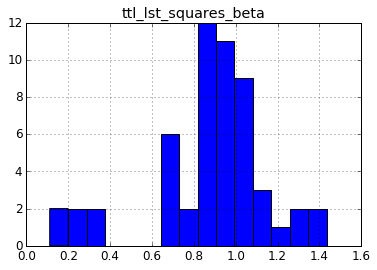

In [60]:
results_df.hist(bins=15)

In [56]:
matplotlib.rcParams.update({'font.size': 14}) # 18 for presentations

Albuquerque
Minneapolis
Baltimore


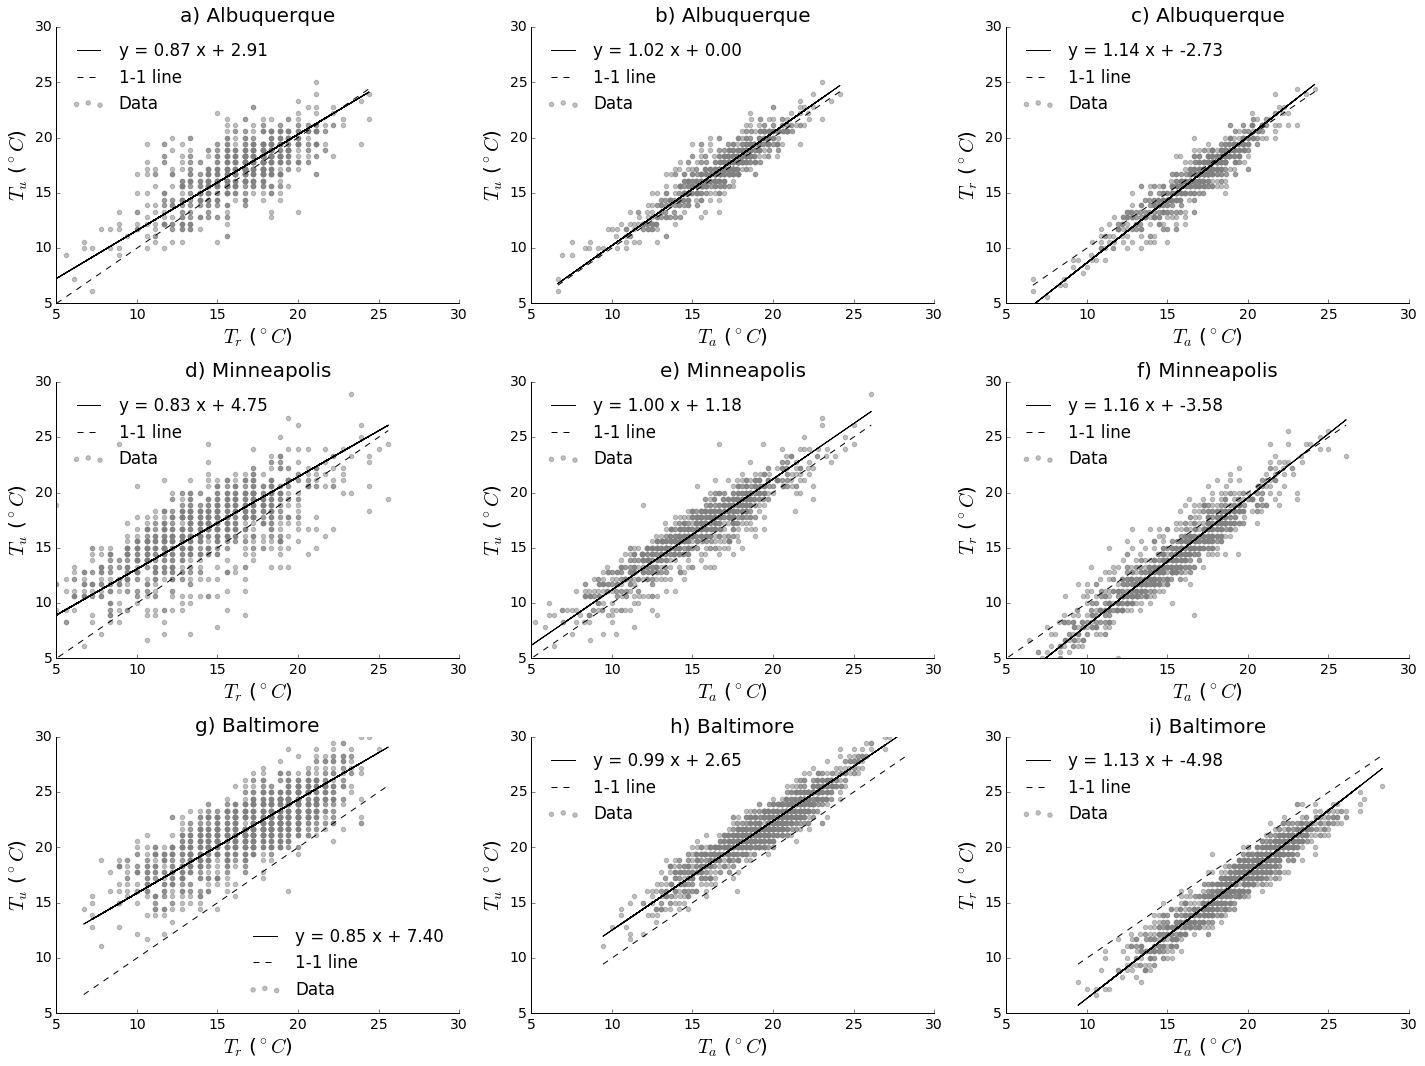

In [73]:
import string
#cities = ['Chicago', 'New York', 'Seattle', 'Miami', 'Albuquerque', 'Baltimore',]
cities = ['Albuquerque', 'Minneapolis', 'Baltimore']
fig = plt.figure(figsize = [20, 15])
i = 1 
fs = 20
for city in cities:
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID, as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID, as_dataframe=True, update = False)
    ###### Import data
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.) 
    # drop data with flags here
    rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
    urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

    # perform total least squares regression
    x = rural_summer
    y = urban_summer
    x = x[y.dropna().index]
    y = y[x.index]
    ax = plt.subplot(3,3,i)
    if city == 'Baltimore': 
        m, b, r, p =easy_scatter_tls(x,y, '%s) %s'%(string.ascii_lowercase[i-1],city), 
                                     '$T_r$ ($^\circ C$)', '$T_u$ ($^\circ C$)', leg_loc = 4) #, leg_loc = 4)#, ax = ax )
    else: 
        m, b, r, p =easy_scatter_tls(x,y, '%s) %s'%(string.ascii_lowercase[i-1],city), 
                                         '$T_r$ ($^\circ C$)', '$T_u$ ($^\circ C$)') #, leg_loc = 4)#, ax = ax )
    ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
    ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
    ax.set_title(ax.get_title(), fontsize = fs)

    plt.xlim(5,30)
    plt.ylim(5,30)
    prettify_plot()
    
    ax = plt.subplot(3,3,i+1)    
    m, b, r, p =easy_scatter_tls((x+y)*.5,y, '%s) %s'%(string.ascii_lowercase[i],city), 
                                     '$T_a$ ($^\circ C$)', '$T_u$ ($^\circ C$)')#, ax = ax )
    plt.xlim(5,30)
    plt.ylim(5,30)
    prettify_plot()
    ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
    ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
    ax.set_title(ax.get_title(), fontsize = fs)

    ax = plt.subplot(3,3,i+2)    
    m, b, r, p =easy_scatter_tls((x+y)*.5,x, '%s) %s'%(string.ascii_lowercase[i+1],city), 
                                     '$T_a$ ($^\circ C$)', '$T_r$ ($^\circ C$)')#, ax = ax )
    prettify_plot()
    plt.xlim(5,30)
    plt.ylim(5,30)
    ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
    ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
    ax.set_title(ax.get_title(), fontsize = fs)
    i = i+3
    
    fig.subplots_adjust(hspace = .35)
    

    
plt.tight_layout()
plt.savefig(results_filepath +'fig01.eps')
plt.savefig(results_filepath +'fig01.pdf')
plt.savefig(results_filepath +'fig01.png')

In [205]:
matplotlib.rcParams.update({'font.size': 14}) # 18 for presentations

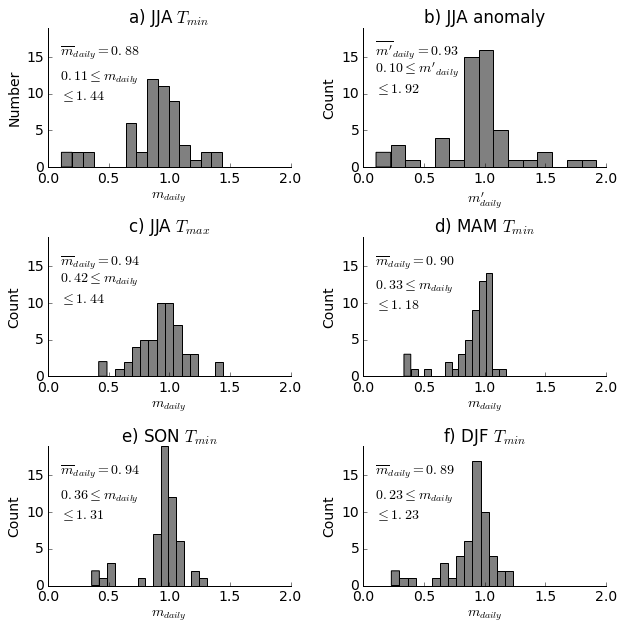

In [207]:
# fig 2: histograms
# a) JJA tmin 
# b) JJA (boxplot? ordered in some order?)
# c) JJA tmax
# d) DJF tmin 
# e) MAM tmin 
# f) SON tmin
fig = plt.figure(figsize = [10, 10])
i = 1 
ax = plt.subplot(3,2,i)
results_df['ttl_lst_squares_beta'].hist(bins=15, ax =ax, facecolor = 'grey')
plt.annotate('$\overline{m}_{daily} = %2.2f$'%results_df['ttl_lst_squares_beta'].mean(), 
             (.05, .8), xycoords = 'axes fraction')
plt.annotate('$ %2.2f \leq {m}_{daily}$ \n$ \leq %2.2f$'%(results_df['ttl_lst_squares_beta'].min(), results_df['ttl_lst_squares_beta'].max()), 
             (.05, .5), xycoords = 'axes fraction')
# plt.annotate('$p=%2.2f$'%scipy.stats.ttest_1samp(results_df['ttl_lst_squares_beta'], 1).pvalue, 
#                 (0.05, .25), xycoords = 'axes fraction')
plt.title('a) JJA $T_{min}$')
ax.set_xlabel('$m_{daily}$')
ax.set_ylabel('Number')
ax.set_xlim(0,2)
ax.set_ylim(0,19)
prettify_plot()

i = i+1
ax = plt.subplot(3,2,i)
anom_results_df = pd.read_csv(results_filepath + "anom_"+ results_filename).set_index('City')
anom_results_df.hist(bins=15, ax=ax, facecolor = 'grey')
plt.annotate('$\overline{m^\prime}_{daily} = %2.2f$'%anom_results_df.mean(), 
                          (.05, .8), xycoords = 'axes fraction')
plt.annotate('$ %2.2f \leq {m^\prime}_{daily} $\n$\leq %2.2f$'%(anom_results_df.min(), anom_results_df.max()),
                          (.05, .55), xycoords = 'axes fraction')
# plt.annotate('$p=%2.2f$'%scipy.stats.ttest_1samp(anom_results_df['ttl_lst_squares_beta'].dropna(), 1).pvalue, 
#                 (0.05, .25), xycoords = 'axes fraction')
plt.title('b) JJA anomaly')
ax.set_xlim(0,2)
ax.set_ylim(0,19)
ax.set_xlabel('$m^\prime_{daily}$')
ax.set_ylabel('Count')
prettify_plot()
i = i+1
ax = plt.subplot(3,2,i)
tmax_results_df=pd.read_csv(results_filepath + "tmax_" + results_filename).set_index('City')
tmax_results_df.hist(bins=15, ax =ax, facecolor = 'grey')
plt.title('c) JJA $T_{max}$')
plt.annotate('$\overline{m}_{daily} = %2.2f$'%tmax_results_df.mean(),
            (.05, .8), xycoords = 'axes fraction')# (.45, 8), xycoords = 'data')
plt.annotate('$ %2.2f \leq {m}_{daily} $\n$ \leq %2.2f$'%(tmax_results_df.min(), tmax_results_df.max()), 
            (.05, .55), xycoords = 'axes fraction')# (.45, 6), xycoords = 'data')
# plt.annotate('$p=%2.2f$'%scipy.stats.ttest_1samp(tmax_results_df['ttl_lst_squares_beta'], 1).pvalue, 
#                 (0.05, .25), xycoords = 'axes fraction')
ax.set_xlim(0,2)
ax.set_ylim(0,19)
ax.set_xlabel('$m_{daily}$')
ax.set_ylabel('Count')
prettify_plot()
i = i+1

for season in ['mam', 'son', 'djf']:
    ax = plt.subplot(3,2,i)
    data = pd.read_csv(results_filepath + season + results_filename).set_index('City')
    data.hist(bins = 15,ax=ax, facecolor = 'grey')
    #plt.title('%s '%season)
    plt.annotate('$\overline{m}_{daily} = %2.2f$'%data.mean(),
                 (.05, .8), xycoords = 'axes fraction')#(.4, 12), xycoords = 'data')
    plt.annotate('$ %2.2f \leq {m}_{daily} $\n$ \leq %2.2f$'%(data.min(), data.max()),
                 (.05, .5), xycoords = 'axes fraction')#(.4, 10), xycoords = 'data')
#     plt.annotate('$p=%2.2f$'%scipy.stats.ttest_1samp(data['ttl_lst_squares_beta'], 1).pvalue, 
#                 (0.05, .25), xycoords = 'axes fraction')
    ax.set_xlim(0,2)
    ax.set_ylim(0,19)
    ax.set_xlabel('$m_{daily}$')
    ax.set_ylabel('Count')
    ax.set_title('%s) %s $T_{min}$'%(string.ascii_lowercase[i-1], season.upper()))
    prettify_plot()
    i = i+1

fig.subplots_adjust(hspace = .5)
plt.savefig(results_filepath +'fig02.eps')
plt.savefig(results_filepath +'fig02.pdf')
plt.savefig(results_filepath +'fig02.png')

In [726]:
# is this significanlty different from 1" 
scipy.stats.ttest_1samp(anom_results_df['ttl_lst_squares_beta'].dropna(), 1)

Ttest_1sampResult(statistic=-1.8226290066723936, pvalue=0.074002798977617829)

In [900]:
# is this significanlty different from 1" 
scipy.stats.ttest_1samp(results_df['ttl_lst_squares_beta'], 1).pvalue

0.0026902400204075363

In [664]:
# how many m_daily are less than 1? 
results_df[results_df['ttl_lst_squares_beta']<=1.0].shape

(38, 8)

In [615]:
# how many are greater than one? 
results_df[results_df['ttl_lst_squares_beta']>=1.0].shape

(16, 8)

In [814]:
# what percentage less than one? 
38/54.

0.7037037037037037

In [589]:
#Which cities greater than one? 
results_df[results_df['ttl_lst_squares_beta']>1]

,ttl_lst_squares_beta,avg_hw_beta,trend_r,trend_u,trend_ur_mean,mean_r,mean_u,mean_mean_ur
City,,,,,,,,
Grand Prairie,1.005454,-9.631364,0.000504,-0.000204,0.000014,22.889781,23.435506,23.045365
Fort Lauderdale,1.399235,-1.262063,0.000751,0.000501,0.000659,22.864945,24.541231,23.694607
Providence,1.102943,1.134363,0.000777,0.000516,0.000616,15.099104,15.903764,15.571044
Virginia Beach,1.251211,11.373874,0.001557,0.001283,0.001418,22.274537,21.090750,21.818325
West Palm Beach,1.341507,-0.738400,0.000091,0.001323,0.000739,22.279379,23.615226,22.944386
Columbus,1.156734,2.075101,0.000461,0.000952,0.000718,15.788293,17.062668,16.409053
Tucson,1.000070,-1.202528,0.000824,0.000802,0.000827,14.963546,22.320276,18.673707
Salt Lake City,1.305800,-1.373712,0.000668,0.000297,0.000602,11.084057,17.995046,14.501172
Omaha,1.050582,-6.917378,-0.000283,0.000694,0.000217,16.523146,18.451726,17.485848


In [ ]:
# what is m_daily

In [651]:
scipy.stats.pearsonr(paired_df['Urban distance'], results_df['ttl_lst_squares_beta'])

(0.31526684283102557, 0.020228515102438355)

In [946]:
scipy.stats.pearsonr(paired_df['Urban Lat'], results_df['ttl_lst_squares_beta'])

(-0.10238936363967527, 0.46128095628675292)

In [947]:
scipy.stats.pearsonr(paired_df['Urban Lon'], results_df['ttl_lst_squares_beta'])

(0.36512004953439342, 0.0066333320891328691)

In [646]:
scipy.stats.pearsonr(results_df['mean_u'], results_df['ttl_lst_squares_beta'])

(0.42020051240398537, 0.001559294765714624)

In [648]:
scipy.stats.pearsonr(results_df['mean_r'], results_df['ttl_lst_squares_beta'])

(0.34074094686584855, 0.011692736754451646)

In [649]:
scipy.stats.pearsonr(results_df['mean_mean_ur'], results_df['ttl_lst_squares_beta'])

(0.40040956189642718, 0.0026983232528541932)

In [700]:
results_df[paired_df['Urban distance'] < 0.1]['ttl_lst_squares_beta'].mean()

0.8170933955380725

In [872]:
restricted_data = results_df[paired_df['Urban distance'] < 0.0899]['ttl_lst_squares_beta'] #~10km

In [873]:
restricted_data[restricted_data>1]

City
Grand Prairie      1.005454
Fort Lauderdale    1.399235
Virginia Beach     1.251211
West Palm Beach    1.341507
Honolulu           1.435754
Dallas             1.025869
Name: ttl_lst_squares_beta, dtype: float64

In [699]:
restricted_data[restricted_data<1].shape

(28,)

In [695]:
6/54.

plt.scatter(paired_df['urban_lcc'], results_df['ttl_lst_squares_beta'])
plt.axhline(1.0)
plt.axvline(.15)

0.1111111111111111

In [784]:
results_df[paired_df['urban_lcc']<=21]['ttl_lst_squares_beta'].mean()

0.925817472726074

In [785]:
results_df[paired_df['urban_lcc']>21]['ttl_lst_squares_beta'].mean()

0.8543528345271478

In [948]:
results_df[paired_df['urban_lcc']<=21]['ttl_lst_squares_beta']

City
West Palm Beach     1.341507
Indianapolis        0.936006
Raleigh             0.837686
Pittsburgh          0.920789
Minneapolis         0.833127
Phoenix             1.117433
San Diego           0.338469
Dallas              1.025869
Washington, D.C.    0.981471
Name: ttl_lst_squares_beta, dtype: float64

In [788]:
scipy.stats.ttest_ind(results_df[paired_df['urban_lcc']<=21]['ttl_lst_squares_beta'], 
                      results_df[paired_df['urban_lcc']>21]['ttl_lst_squares_beta'], equal_var = False)

Ttest_indResult(statistic=0.71745144000549887, pvalue=0.48698967003022076)

In [950]:
# 21-24 developed land, 21 least developed, 24 most developed
results_df['ttl_lst_squares_beta'][(paired_df['urban_lcc']>=21) & (paired_df['urban_lcc']<=24)].mean()

0.8465013410303874

In [965]:
results_df['ttl_lst_squares_beta'][(paired_df['urban_lcc']<23) | (paired_df['urban_lcc']>24)].mean()

0.9326206841318408

In [966]:
results_df['ttl_lst_squares_beta'][(paired_df['urban_lcc']>=23) & (paired_df['urban_lcc']<=24)].mean()

0.7657152419766795

In [960]:
scipy.stats.ttest_ind(results_df['ttl_lst_squares_beta'][(paired_df['urban_lcc']<23) | (paired_df['urban_lcc']>24)], 
                      results_df['ttl_lst_squares_beta'][(paired_df['urban_lcc']>=23) & (paired_df['urban_lcc']<=24)], 
                     )

Ttest_indResult(statistic=2.2086266990825374, pvalue=0.031720663225347098)

In [972]:
results_df['ttl_lst_squares_beta'][(paired_df['urban_lcc']>=23) & (paired_df['urban_lcc']<=24)]> 1

City
Grand Prairie      True
Irvine            False
Virginia Beach     True
Oakland           False
Louisville        False
Columbus           True
San Bernardino    False
Baltimore         False
San Jose          False
Sacramento        False
Portland          False
Omaha              True
Cleveland          True
Milwaukee         False
Seattle           False
St. Louis         False
Philadelphia      False
San Francisco     False
Denver            False
Chicago           False
Los Angeles       False
Name: ttl_lst_squares_beta, dtype: bool

In [640]:
scipy.stats.pearsonr(paired_df['urban_lcc'].dropna(), results_df['ttl_lst_squares_beta'][paired_df['urban_lcc'].dropna().index])

(0.24721787204318457, 0.074314408674413274)

In [653]:
scipy.stats.pearsonr(paired_df['rural_lcc'].dropna(), results_df['ttl_lst_squares_beta'][paired_df['urban_lcc'].dropna().index])

(0.027923514124772859, 0.84267150626424214)

In [637]:
paired_df.columns

Index([u'City', u'Unnamed: 0', u'City.1', u'Urban station', u'Urban Lat',
       u'Urban Lon', u'Urban brightness', u'Urban start', u'Urban end',
       u'Rural station', u'Rural Lat', u'Rural Lon', u'Rural brightness',
       u'Rural start', u'Rural end', u'Urban distance', u'Rural distance',
       u'urban_lcc', u'rural_lcc'],
      dtype='object')

In [741]:
6/28.

0.21428571428571427

In [ ]:
results_df['ttl_lst_squares_beta']

In [792]:
scipy.stats.ttest_1samp(results_df[paired_df['urban_lcc']<=24]['ttl_lst_squares_beta'], 1)

Ttest_1sampResult(statistic=-3.0285797332828315, pvalue=0.0044604480157276489)

In [817]:
# if we cut out the non urban lcc, does it change our answer? 
answer = results_df['ttl_lst_squares_beta'][(paired_df['urban_lcc']<=24) & (paired_df['urban_lcc']>22)] < 1

In [818]:
answer[answer ==True].shape, answer.shape

((16,), (21,))

In [819]:
34/46.

0.7391304347826086

In [132]:
# There are 16 cities with m > 1. Of these stations, how many are either in less developed lcc's or far away from urban center? 
m_greater_1 = results_df['ttl_lst_squares_beta'][results_df['ttl_lst_squares_beta'] >1 ]
m_greater_1[((paired_df['urban_lcc']<23) & (paired_df['urban_lcc']>24)) | (paired_df['Urban distance'] > 0.0899)].shape

(10,)

In [136]:
# What is m_daily mean without these 10 cities? 
results_df['ttl_lst_squares_beta'].drop(m_greater_1[((paired_df['urban_lcc']<23) & (paired_df['urban_lcc']>24)) | (paired_df['Urban distance'] > 0.0899)].index).mean()

0.8279132185854546

In [36]:
# read in data for fig 3
# fig 3 

x = np.arange(-5,6)
compositeTempDF =  .5*(pd.read_csv(results_filepath + 'composite_urban_tmin_mean.csv').set_index('City') + pd.read_csv(results_filepath + 'composite_rural_tmin_mean.csv').set_index('City'))
compositeTempDF.columns = x
compositeUHIDF  = pd.read_csv(results_filepath + 'composite_UHI_tmin_mean.csv').set_index('City')
compositeUHIDF.columns = x

city = 'Baltimore'
urbanID = paired_df.loc[city]['Urban station']
ruralID = paired_df.loc[city]['Rural station']
print(city)
# # Downloadd from NCDC the station data, using the station ID listed in station list
urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                     as_dataframe=True, update = False)
ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                     as_dataframe=True, update = False)
if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2000-01-01':].index, ruraldata['TMIN']['2000-01-01':].index).shape[0] > 300): 
    ######
    ###### Import data
    ######
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.)  
    # drop data with flags here
    rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
    urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
    mean_summer = .5*(rural_summer.add(urban_summer))

    #for city in cities: 
    x = rural_summer
    y = urban_summer
    x = x[y.dropna().index]
    y = y[x.index]
    ind = ~np.isnan(y) & ~np.isnan(x)

    #X = np.array([x[ind].values,y[ind].values])
    #u, s, v = np.linalg.svd(X-X.mean(), full_matrices=False)

    numhw = 50
    final_num_hw = 15#50
    #hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
    #hw_ids = np.argsort(v[0])[0:final_num_hw]
#         hw_ids = np.argsort((x[ind]-y[ind])*.5)
#         hw_dates = x[ind].iloc[hw_ids].index
#         finalhw = rural_tmin[x[ind].iloc[hw_ids].index]
    # compute

    hw_ids = np.argsort((urban_summer+rural_summer).dropna()*-.5) # negative gives you the hottest days
    hw_dates = x[ind].iloc[hw_ids].index
    hottestmin = rural_summer[hw_dates]
    minheatwaves = hottestmin[0:numhw]

    Ns = []
    m = 0 
    for n in range(1,final_num_hw+1): 
        old = m
        try: 
            # while the two days are 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            minheatwaves = hottestmin[0:20]
            try: 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                print('out of bounds')
        try: 
            if old ==m : 
                Ns.append(minheatwaves.sort_index().index[m])
            else: 
                Ns.append(minheatwaves.sort_index()[old:m].argmax())
        except: 
            'random error'
        m = m+1
    finalhw = hottestmin[Ns].sort_values(ascending=False)

    # Preallocate composite matrices to plot
    compositeTemp = np.zeros([final_num_hw, 11])
    compositeTemp2 = np.zeros([final_num_hw, 11])

    compositeUHI = np.zeros([final_num_hw, 11])
    ii = 0
    for dates in finalhw.index[:]: 
        compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        #compositeTemp2[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        compositeTemp2[ii,:]= mean_summer[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
        ii = ii+1

#         composite_urban_tmin.loc[city] = np.nanmean(compositeTemp, axis=0)
#         composite_rural_tmin.loc[city] = np.nanmean(compositeTemp2, axis=0)
#         composite_UHI_tmin.loc[city] = np.nanmean(compositeUHI, axis=0)

Baltimore


/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[column_name][dates] =

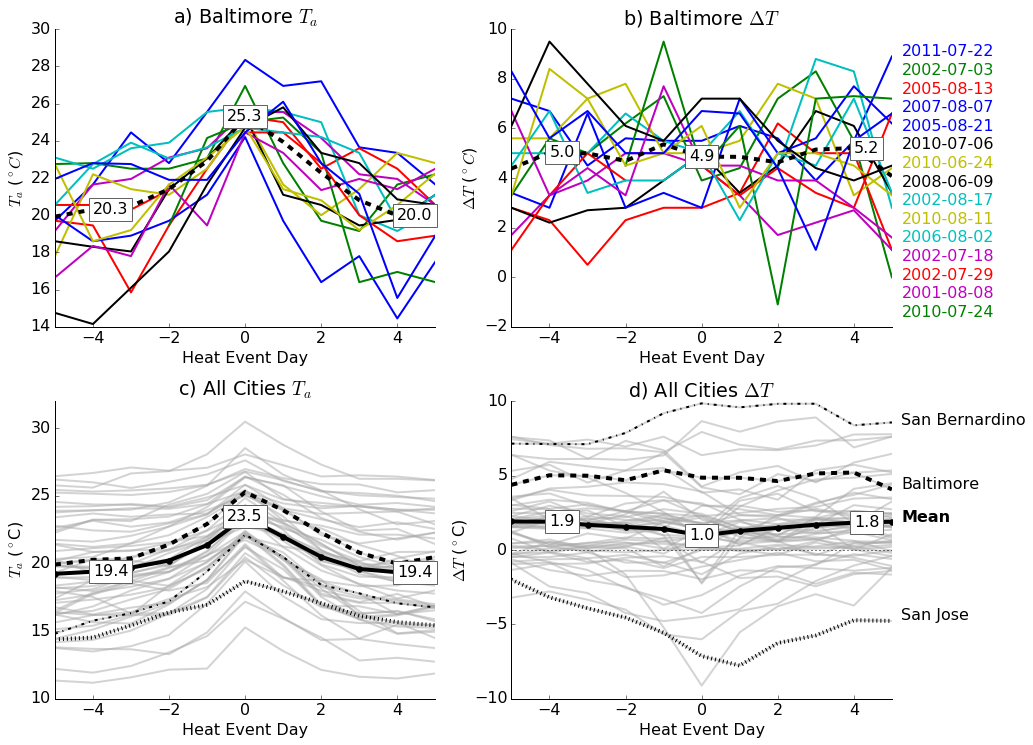

In [37]:
# figure 3
fig = plt.figure(figsize=[15,12])
bmorec = 'k'

############# a) plot bmore temp
plt.subplot(2,2,1)
x = np.arange(-5,6)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp2.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp2, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s $T_a$'%city)
plt.ylabel('$T_a$ ($^\circ C$)')
plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
prettify_plot()

xx = 1
yy = np.nanmean(compositeTemp2,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 5
yy = np.nanmean(compositeTemp2,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 9
yy = np.nanmean(compositeTemp2,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')
plt.xlim([-5,5])

############# b) plot bmore UHI
plt.subplot(2,2,2)
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)
plt.title('b) %s $\Delta T$'%city)
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.xlabel('Heat Event Day')
xx = 1
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 5
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 9
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')

prettify_plot()
a = pd.DataFrame(compositeUHI[:,10],columns=['UHI'], index = finalhw.index)
a['ind'] = np.arange(0, 15)
ii = 0 
for date in a.sort_values('UHI', ascending = False,).index: 
    i = a['ind'][date]
    plt.text(5.25, compositeUHI[0][10]-.75*ii,
             date, color = tHandle[i].get_color(), horizontalalignment='left')#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    ii = ii+1
plt.xlim([-5,5])

############# c) plot all cities UHI
city1 =  'San Bernardino'#'Tucson'#'Salt Lake City'
city2 = 'San Jose' # 'Austin' #
bmorec = 'k'
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc[city1], ':', color = 'k', alpha = 1, linewidth = 4, label = '%s'%city1)
plt.plot(x, compositeTempDF.loc[city2], '-.', color = 'k', alpha = 1, linewidth = 2, label = '%s'%city1)
plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heat Event Day')
plt.ylabel('$T_a$ ($^\circ$C)')
plt.title('c) All Cities $T_a$')
plt.xlim([-5,5])
plt.ylim([10,32])
xx = -4
yy = compositeTempDF.mean()[xx]
plt.text(-4,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 4
yy = compositeTempDF.mean()[xx]
plt.text(4,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')
prettify_plot()

############# d) plot all cities UHI
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) All Cities $\Delta T$')
prettify_plot()

xx = -4
yy = compositeUHIDF.mean()[xx]
plt.text(-4,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 4
yy = compositeUHIDF.mean()[xx]
plt.text(4,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')
plt.text(5.25,compositeUHIDF[4].loc[city1],'%s'%city1)
plt.text(5.25,compositeUHIDF[4].loc[city2],'%s'%city2)
plt.text(5.25,compositeUHIDF.loc['Baltimore'][5],'Baltimore', color = bmorec)
plt.text(5.25, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')
plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, 
         label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc[city1], '-.', color = 'k', alpha = 1, linewidth = 2, 
         label = '%s'%city1)
plt.plot(x, compositeUHIDF.loc[city2], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, 
         label = '%s'%city2)
#plt.ylim([-12,12])
plt.xlim([-5,5])
prettify_plot()
############# make adjustments and save

fig.subplots_adjust(hspace = .25)
plt.savefig(results_filepath +'fig03.eps')
plt.savefig(results_filepath +'fig03.pdf')
plt.savefig(results_filepath +'fig03.png')

In [137]:
# what is the equivalent slope in degree/degree
.9/(23.5-19.4)

0.21951219512195114

In [545]:
# in how many cities does the UHI decrease on hw day 0? 
compositeUHIDF[compositeUHIDF[0] < compositeUHIDF[-1]].index.shape

(32,)

In [556]:
32/54.

0.5925925925925926

In [839]:
# in how many cities does the UHI decrease by more than 1 degree? 
compositeUHIDF[(compositeUHIDF[0] - compositeUHIDF[-4] < -1)].index.shape

(19,)

In [838]:
# in how many cities does the UHI remain unchanged (ie, less than a degree)? 
compositeUHIDF[(-1 <compositeUHIDF[0] - compositeUHIDF[-4]) &  (compositeUHIDF[0] - compositeUHIDF[-4]< 1)].index.shape

(29,)

In [833]:
# in how many cities does the UHI increase by more than 1 degree? 
compositeUHIDF[(compositeUHIDF[0] - compositeUHIDF[-4] > 1)].index.shape

(6,)

In [840]:
19+29+6

54

In [824]:
# in how many cities does the UHI increase by more than 1 degree? 
compositeUHIDF[(compositeUHIDF[0] - compositeUHIDF[-4] > -1)].index.shape

(35,)

In [663]:
# in how many cities does the UHI differ by 
compositeUHIDF[(compositeUHIDF[0] - compositeUHIDF[-4] < 1)].index.shape

(53,)

In [843]:
# in how many cities does the UHI increase on hw day 0? 
compositeUHIDF[compositeUHIDF[0] - compositeUHIDF[-4] >1].index.shape

(6,)

In [845]:
# are the cities in which m_daily > 1 the same cities which don't decrease during hw? 
np.intersect1d(compositeUHIDF[compositeUHIDF[0] - compositeUHIDF[-4] >1].index, 
               results_df[results_df['ttl_lst_squares_beta'] > 1]['ttl_lst_squares_beta'].index).shape

(4,)

In [847]:
# are the cities in which m_daily > 1 the same cities which decrease during hw? 
np.intersect1d(compositeUHIDF[compositeUHIDF[0] > compositeUHIDF[-4]].index, 
               results_df[results_df['ttl_lst_squares_beta'] > 1]['ttl_lst_squares_beta'].index).shape

(9,)

In [848]:
compositeUHIDF[compositeUHIDF[0] > compositeUHIDF[-4]].shape

(17, 11)

In [846]:
# are the cities in which m_daily > 1 the same cities which don't change during hw? 

np.intersect1d(compositeUHIDF[(-1 <compositeUHIDF[0] - compositeUHIDF[-4]) &  (compositeUHIDF[0] - compositeUHIDF[-4]< 1)].index, 
               results_df[results_df['ttl_lst_squares_beta'] > 1]['ttl_lst_squares_beta'].index).shape

(11,)

In [557]:
38/54.

0.7037037037037037

In [436]:
compositeTempDF.shape

(54, 11)

In [437]:
compositeTempDF[compositeUHIDF[0] < 0].dropna().shape

(16, 11)

In [438]:
16/54.

0.2962962962962963

In [439]:
54-16

38

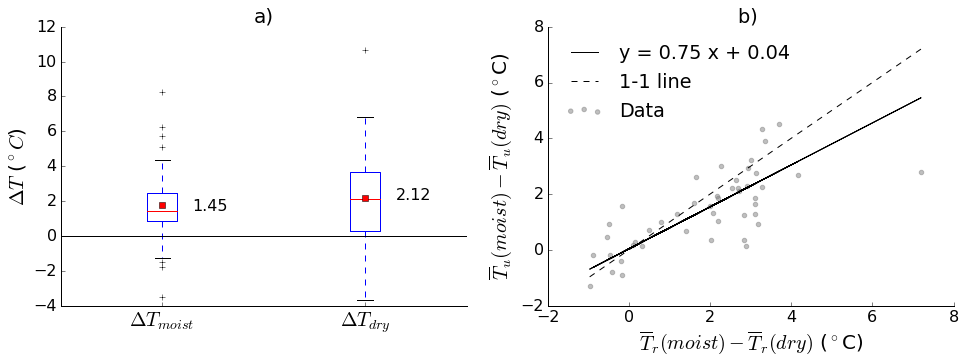

In [34]:
# fig 4: moist/dry
#paired_df = pd.read_csv('../heat/USpairs2005-2015.csv').set_index('City', drop = False)
#paired_df = paired_df[paired_df['Urban distance'] < 0.25]
fpath = 'plots/version6/ssc/'
ind = paired_df.index#[paired_df['Urban distance']<.25].index
UHI_resultsDF   = pd.read_csv(fpath+'sscanalysis.csv').set_index('City').loc[ind]
urban_resultsDF = pd.read_csv(fpath+'urban_sscanalysis.csv').set_index('City').loc[ind]
rural_resultsDF = pd.read_csv(fpath+'rural_sscanalysis.csv').set_index('City').loc[ind]
# set dry, moist
urban_resultsDF['Dry'] = urban_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
urban_resultsDF['Moist'] = urban_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
rural_resultsDF['Dry'] = rural_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
rural_resultsDF['Moist'] = rural_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
UHI_resultsDF['Dry'] = UHI_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
UHI_resultsDF['Moist'] = UHI_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)

fig = plt.figure(figsize = [16,5])
ax = plt.subplot(121)
data = [ urban_resultsDF['Moist'].dropna().subtract(rural_resultsDF['Moist'].dropna()), 
        urban_resultsDF['Dry'].dropna().subtract(rural_resultsDF['Dry'].dropna()), 
       ]
handles = plt.boxplot(data, showmeans = True)
plt.ylabel('$\Delta T$ ($^\circ C$)')
#plt.xticks([1,2],['$T_{u}- T_r( {moist} )$','$T_{u}- T_r( {dry} )$']) 
#plt.xticks([1,2],['Urban- rural\n moist', 'Urban-rural\n dry'],  fontsize = fs)
plt.xticks([1,2],['$\Delta T_{moist}$', '$\Delta T_{dry}$'],  fontsize = fs)

plt.title('a)')
plt.axhline(0, color ='k')
xx = 1.15
for item in data: 
    #plt.annotate('%2.2f'%np.mean(item), xy = (xx, np.mean(item)))
    plt.annotate('%2.2f'%np.median(item), xy = (xx, np.median(item)))
    xx = xx+1
prettify_plot()
ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
ax.set_title(ax.get_title(), fontsize = fs)
    
ax = plt.subplot(122)
easy_scatter_tls(rural_resultsDF['Moist'].subtract(rural_resultsDF['Dry']),
                 urban_resultsDF['Moist'].subtract(urban_resultsDF['Dry']),
                '', '$\overline{T}_r (moist) - \overline{T}_r (dry)$ ($^\circ $C)', 
                '$\overline{T}_u (moist) - \overline{T}_u (dry)$ ($^\circ $C)')
# data = [urban_resultsDF['Moist'].dropna(), 
#         urban_resultsDF['Dry'].dropna(),# urban_resultsDF['Dry'].dropna(), 
#         rural_resultsDF['Moist'].dropna(),
#         rural_resultsDF['Dry'].dropna(), 
#        #UHI_resultsDF['Moist'].dropna(), UHI_resultsDF['Dry'].dropna(),
#        ]
# dict = plt.boxplot(data, showmeans = True)
# plt.ylabel('Temperature ($^\circ C$)')
# plt.xticks([1,2,3,4],['urban \n moist', 'urban \n dry','rural \n moist',  'rural \n dry'])
# xx = 1.25
# for item in data: 
# #    plt.annotate('%2.2f'%np.median(item), xy = (xx, np.median(item)))
#     plt.annotate('%2.2f'%np.mean(item), xy = (xx, np.mean(item)))
#     xx = xx+1
#ax.set_title('')
ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
ax.set_title(ax.get_title(), fontsize = fs)
fig.patch.set_alpha(0.)

plt.title('b) ')
prettify_plot()
plt.savefig(results_filepath +'fig04.eps', bbox_inches='tight')
plt.savefig(results_filepath +'fig04.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'fig04.png', bbox_inches='tight')

In [21]:
matplotlib.rcParams.update({'font.size': 16}) # 18 for presentations

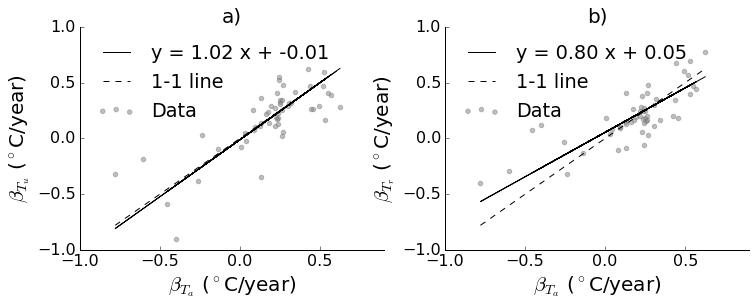

In [30]:
# fig 5
plt.figure(figsize =[12,4])
# plt.subplot(131)
# easy_scatter_tls(365*results_df['trend_r'],365*results_df['trend_u'],
#            '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
#            r'$\beta_{T_u}$ ($^\circ$C/year)')
# r, p = scipy.stats.pearsonr(results_df['trend_r'], results_df['trend_u'])
# plt.annotate('r = %2.2f'%r, xy = (.8, .2), xycoords= "axes fraction") 
# plt.annotate('p = %2.2f'%p, xy = (.8, .15), xycoords= "axes fraction") 
# prettify_plot()
fs = 20
ax = plt.subplot(121)

m,b,r,p = easy_scatter_tls(365*results_df['trend_ur_mean'],365*results_df['trend_u'],
           'a)', r'$\beta_{T_a}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{T_u}$ ($^\circ$C/year)')
plt.ylim([-1,1])
plt.xlim([-1, 0.9])
ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
ax.set_title(ax.get_title(), fontsize = fs)

prettify_plot()
ax = plt.subplot(122)
m,b,r,p = easy_scatter_tls(365*results_df['trend_ur_mean'],365*results_df['trend_r'],
           'b)', r'$\beta_{T_a}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{T_r}$ ($^\circ$C/year)')
plt.ylim([-1,1])
plt.xlim([-1, 0.9])
ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
ax.set_title(ax.get_title(), fontsize = fs)
prettify_plot()

# m,b,r,p = easy_scatter_tls(365*results_df['trend_ur_mean'],
#                            365*results_df['trend_u'].subtract(results_df['trend_r']),
#            '', r'$\beta_{\overline{T_u, T_r}}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
#            r'$\beta_{T_u} - \beta_{T_r}$ ($^\circ$C/year)')
# plt.axhline(0, linestyle =':', color = 'k')
# plt.axvline(0, linestyle =':', color = 'k')
prettify_plot()

plt.savefig(results_filepath +'fig05.eps', bbox_inches = 'tight')
plt.savefig(results_filepath +'fig05.pdf', bbox_inches = 'tight')
plt.savefig(results_filepath +'fig05.png', bbox_inches = 'tight')

In [149]:
20/3.*2

13.333333333333334

In [90]:
# Are beta tr and beta tu significantly different 
print(scipy.stats.ttest_ind(results_df['trend_r'], results_df['trend_u'], equal_var = False))
print(scipy.stats.ttest_rel(results_df['trend_r'], results_df['trend_u']))
#scipy.stats.linregress(results_df['trend_r'],  results_df['trend_u'])

Ttest_indResult(statistic=0.48650075994797076, pvalue=0.62765297592169045)
Ttest_relResult(statistic=0.57801370102916838, pvalue=0.56570277692801785)


In [624]:
scipy.stats.pearsonr(results_df['trend_r'], results_df['trend_u'])

(0.29702790075205859, 0.029175017220663679)

In [ ]:
matplotlib.rcParams.update({'font.size': 16) # 18 for presentations

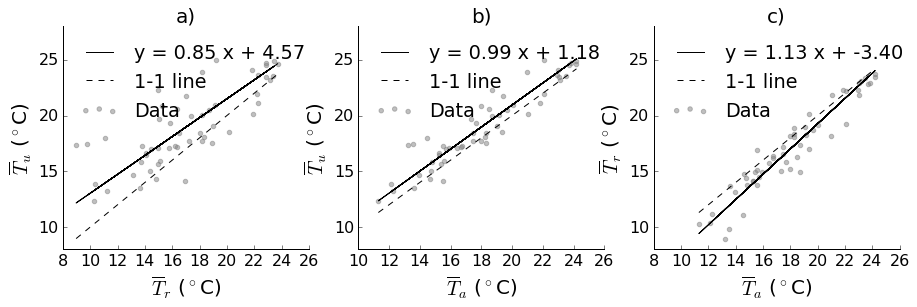

In [31]:
# fig 6: means
fs = 20
plt.figure(figsize=[15,4])
ax =plt.subplot(131)
m,b,r,p = easy_scatter_tls(results_df['mean_r'],
                           results_df['mean_u'], 
                           'a)', '$\overline{T}_r$ ($^\circ$C)', '$\overline{T}_u$ ($^\circ$C)')#, leg_loc = 4)
plt.xlim([8,26])
plt.ylim([8,28])
ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
ax.set_title(ax.get_title(), fontsize = fs)

prettify_plot()

ax = plt.subplot(132)
m,b,r,p = easy_scatter_tls(results_df['mean_mean_ur'],
                           results_df['mean_u'], 
                           'b)', '$\overline{T}_a$ ($^\circ$C)', '$\overline{T}_u$ ($^\circ$C)')#, leg_loc = 4)
plt.ylim([8,28])
ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
ax.set_title(ax.get_title(), fontsize = fs)
prettify_plot()

ax = plt.subplot(133)
m,b,r,p = easy_scatter_tls(results_df['mean_mean_ur'],
                           results_df['mean_r'], 
                           'c)', '$\overline{T}_a$ ($^\circ$C)', '$\overline{T}_r$ ($^\circ$C)')
plt.xlim([8,26])
plt.ylim([8,28])
prettify_plot()
ax.set_ylabel(ax.get_ylabel(), fontsize = fs)
ax.set_xlabel(ax.get_xlabel(), fontsize = fs)
ax.set_title(ax.get_title(), fontsize = fs)


plt.savefig(results_filepath +'fig06.eps', bbox_inches = 'tight')
plt.savefig(results_filepath +'fig06.pdf', bbox_inches = 'tight')
plt.savefig(results_filepath +'fig06.png', bbox_inches = 'tight')

# Supplementary Figures

In [76]:
def map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ to Temperature Change', data_label = 'm$_{JJA}$ ($^\circ$C$ / ^\circ $C)', label_city = False, c_insignificant = np.array([]), cmap = matplotlib.cm.YlOrRd,  bounds = np.linspace(0,2,11)) : 
    # plots a map and histogram of data, a pandas dataframe with cities in the index 
    # paired_df 
    # results_df[results_df['P-value']>0.05]
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes([0, 0, 1, 1],
                       projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.set_title(title)
    # download default shapefils from natura_earth using cartopy's shapereader
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Plot background state map
    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = '.9'#[0.9375, 0.9375, 0.859375]
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    # define data
    data = data[~np.isnan(data)]
    # Set up colors for plotting
    #cmap = matplotlib.cm.coolwarm
    #cmap = matplotlib.cm.YlOrRd
    c = data
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    marker_size = 150

    # plot data

    ax.set_title('a) ')
    # plot significance
    #c_insignificant = results_df[results_df['P-value']>0.05]
    if c_insignificant.shape[0] > 0 : 
        ax.scatter(paired_df.set_index('City').loc[c_insignificant.index]['Urban Lon'], paired_df.set_index('City').loc[c_insignificant.index]['Urban Lat'], 
                #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
                    c = c[c_insignificant.index].values, s = marker_size-50, 
                   transform=ccrs.Geodetic(),edgecolors= 'None',
                   cmap = cmap, norm = norm, zorder =1)        
        sig_cities = np.setdiff1d(paired_df.index,c_insignificant.index )
        plotHandle = ax.scatter(paired_df.set_index('City').loc[sig_cities]['Urban Lon'], 
                                paired_df.set_index('City').loc[sig_cities]['Urban Lat'], 
                            c = c[sig_cities].values, s = marker_size, alpha = 1, 
                            transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                     cmap = cmap,
                     norm = norm, zorder = 1, )
    else: 
        plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )

    if label_city == True: 
        for city, lon, lat in zip(c.index, paired_df.set_index('City').loc[c.index]['Urban Lon'].values, paired_df.set_index('City').loc[c.index]['Urban Lat'].values): 
            if city != 'Honolulu': 
                ax.text(lon+.5,lat, city,
                        #xy = (paired_df.set_index('City').loc[c.index]['Rural Lon'].values, paired_df.set_index('City').loc[c.index]['Rural Lat'].values), 
                       transform = ccrs.Geodetic(), 
                        horizontalalignment='left',)


#     cb = plt.colorbar(plotHandle, label = data_label, #'Slope m$_{JJA}$ ($^\circ$C$ / ^\circ $C)',
#                       orientation='horizontal', shrink = .5)
#     cb.outline.remove()

    ##### Histogram 
    sub_ax = plt.axes([0.05, 0.0, 0.22, 0.25])
    #plot data
    n, bins, patches = sub_ax.hist(data,13, facecolor = 'darkgray', linewidth=0)
    # annotate and label 
    sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .15), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, 0), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.set_xlabel(data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
    sub_ax.set_ylabel('Count')
    sub_ax.set_title('b)')
    if data.max() < 0.1 : 
        sub_ax.set_xticks(sub_ax.get_xticks()[::2])

    # set histogram colors 
    m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
    m._A = []

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
        plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
    #plt.colorbar(m)
    prettify_plot()
    return fig, ax, sub_ax

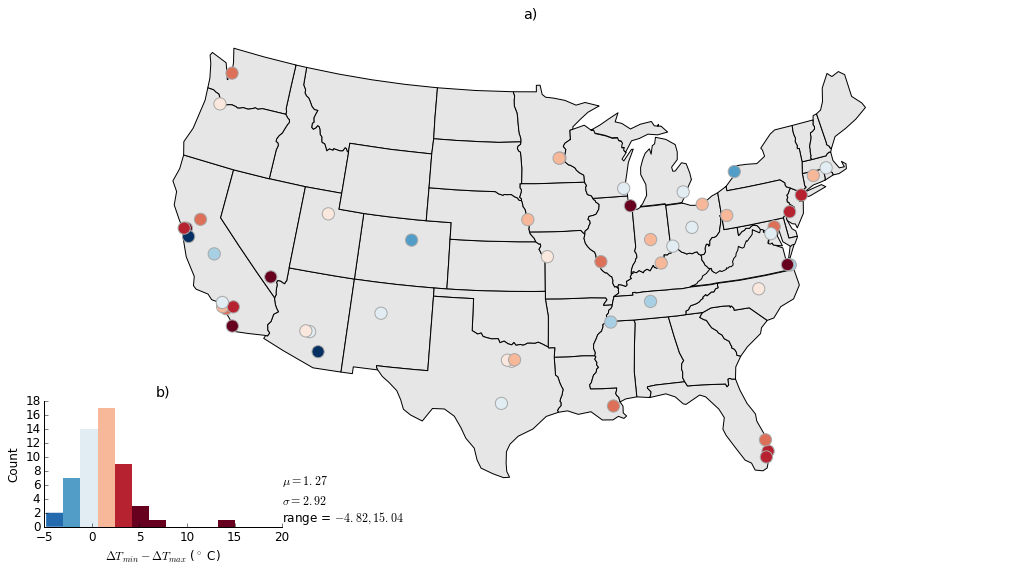

In [1112]:
# S1: Daytime versus nighttime
nighttime = results_df['mean_u'] - results_df['mean_r']
daytime = pd.read_csv('plots/version6/tmax/US_results_cleaned_data.csv').set_index('City')['mean UHI']
data = nighttime - daytime
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Heatwaves', 
                    data_label='$\Delta T_{min} - \Delta T_{max}$ ($^\circ$ C)',
                   #c_insignificant = results_df[results_df['hw_pvalueWald']>0.05], 
                                cmap = matplotlib.cm.RdBu_r, bounds = np.linspace(-5,5,11),
                ) 
#sub_ax.set_xticks(sub_ax.get_xticks()[::2])
ax.set_title('a)')
sub_ax.set_title('b)')
#plt.savefig(results_filepath+ 'figure2e_2f.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS01.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS01.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'figS01.png', bbox_inches='tight')

In [1118]:
data[data> 0].dropna().shape

(35,)

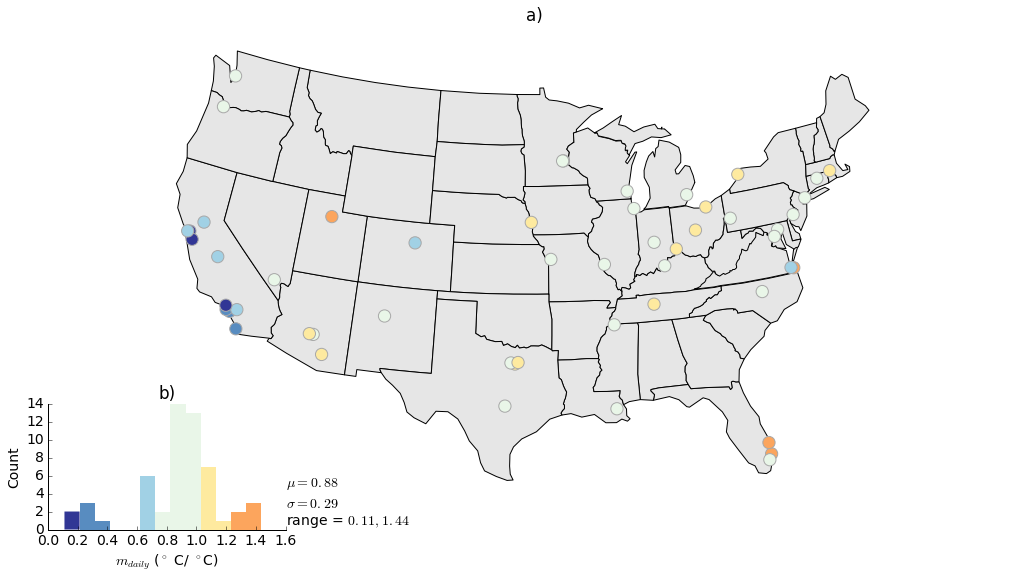

In [84]:
# S2: Map of m_daily

data = results_df['ttl_lst_squares_beta']
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Heatwaves', 
                    data_label='$m_{daily}$ ($^\circ$ C/ $^\circ $C)',
                   #c_insignificant = results_df[results_df['hw_pvalueWald']>0.05], 
                                #cmap = matplotlib.cm.YlOrRd,
                                cmap = matplotlib.cm.RdYlBu_r,
                                bounds = np.linspace(0,2,9),
                ) 
#sub_ax.set_xticks(sub_ax.get_xticks()[::2])
ax.set_title('a)')
sub_ax.set_title('b)')

plt.savefig(results_filepath +'figS02.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS02.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'figS02.png', bbox_inches='tight')

In [154]:
results_df['mean_u'].sort_values().index

Index([u'San Francisco', u'Portland', u'Oakland', u'Seattle', u'San Jose',
       u'Milwaukee', u'Denver', u'Buffalo', u'Detroit', u'Sacramento',
       u'Providence', u'St. Paul', u'Minneapolis', u'Cleveland', u'Columbus',
       u'Pittsburgh', u'Albuquerque', u'Irvine', u'Hartford',
       u'San Bernardino', u'San Diego', u'Los Angeles', u'Long Beach',
       u'Cincinnati', u'Salt Lake City', u'Nashville', u'Indianapolis',
       u'Omaha', u'Fresno', u'Kansas City', u'Chicago', u'New York',
       u'Louisville', u'Washington, D.C.', u'Memphis', u'Raleigh', u'Norfolk',
       u'Philadelphia', u'St. Louis', u'Virginia Beach', u'Baltimore',
       u'Austin', u'Tucson', u'Honolulu', u'Grand Prairie', u'Ft. Worth',
       u'West Palm Beach', u'Phoenix', u'New Orleans', u'Fort Lauderdale',
       u'Mesa', u'Dallas', u'Miami', u'Las Vegas'],
      dtype='object', name=u'City')

Skipping Portland
Skipping Arlington
Skipping Las Vegas
0.877030288794


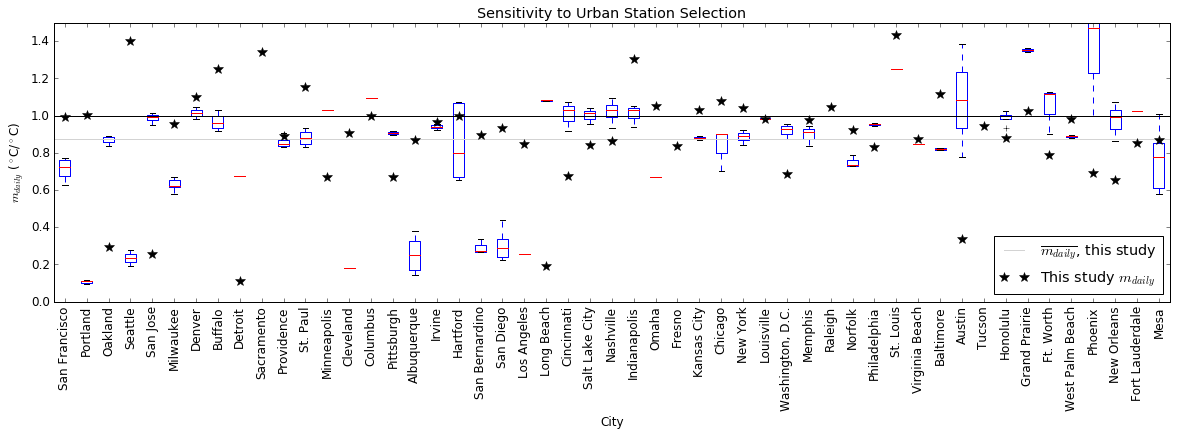

In [156]:
# error bar figures
# put the cities in order of hottest cities first
#cities = old_results['mean urban'].sort_values(ascending = False)
#urban 
fpath ='plots/version7/errorbars/'
cities = results_df['mean_u'].sort_values().index #paired_df['City'].values
M_list = []
for city in cities: #i in range(0,cities.shape[0]): # probalby need to redo 1-15
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(fpath+'slopes/'+ city.replace(" ", "")[0:5]+'m_urban.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
    except IOError: 
        print('Skipping %s'%city)

plt.figure(figsize=[20,5])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')
#Now load the calculated results 
#set up fake x axis
X = np.arange(1, cities.shape[0]+1)
Y = results_df['ttl_lst_squares_beta']
ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m_{daily}}$, this study')
ax.axhline(1, color = 'black', )
ax.plot(X,Y, '*', color = 'black', markerSize = 10, label = 'This study $m_{daily}$')
ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)
ax.set_ylabel('$m_{daily}$ ($^\circ$C/$^\circ$C)')
ax.set_title('Sensitivity to Urban Station Selection')
plt.ylim([0., 1.5])
plt.legend(loc = 4)
plt.savefig(results_filepath +'figS03.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS03.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'figS03.png', bbox_inches='tight')
print(Y.mean())

In [109]:
# how many stations on average is this? 
arr = np.zeros(len(M_list))
i = 0
for row in M_list :
    arr[i] = len(row)
    i = i+1
arr.mean()

2.6862745098039214

In [110]:
df = np.ones(len(M_list))*np.nan
i = 0
for row in M_list: 
    df[i] = np.nanmean(row)
    i = i+1

/Users/annascott2/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [111]:
varying_urban_m = pd.DataFrame(df, columns=['mean_m'], index=paired_df.drop(['Grand Prairie', 'Las Vegas', 'Portland']).index)

In [112]:
varying_urban_m.mean()

mean_m    0.839389
dtype: float64

In [1093]:
varying_urban_m[varying_urban_m >1].dropna().shape

(14, 1)

Skipping Arlington


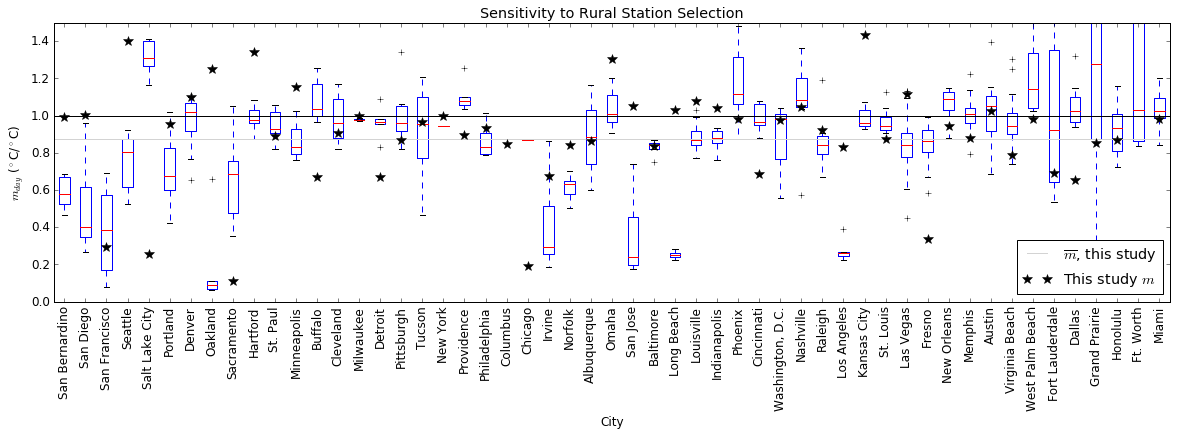

In [158]:
# error bar figures
# put the cities in order of hottest cities first
#cities = old_results['mean urban'].sort_values(ascending = False)
#urban 
fpath ='plots/version7/errorbars/'
#cities = paired_df.index
cities = results_df['mean_r'].sort_values().index #paired_df['City'].values
M_list = []
for city in cities: #i in range(0,cities.shape[0]): # probalby need to redo 1-15
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(fpath+'slopes/'+ city.replace(" ", "")[0:5]+'m_rural.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
    except IOError: 
        print('Skipping %s'%city)

plt.figure(figsize=[20,5])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')
#Now load the calculated results 
#set up fake x axis
X = np.arange(1, cities.shape[0]+1)
Y = results_df['ttl_lst_squares_beta']
ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$, this study')
ax.axhline(1, color = 'black', )
ax.plot(X,Y, '*', color = 'black', markerSize = 10, label = 'This study $m$')
ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)
ax.set_ylabel('$m_{day}$ ($^\circ$C/$^\circ$C)')
ax.set_title('Sensitivity to Rural Station Selection')
plt.ylim([0., 1.5])
plt.legend(loc=4)
plt.savefig(results_filepath +'figS04.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS04.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'figS04.png', bbox_inches='tight')

In [100]:
# how many stations on average is this? 
arr = np.zeros(len(M_list))
i = 0
for row in M_list :
    arr[i] = len(row)
    i = i+1
arr.mean()

11.018867924528301

In [101]:
df = np.ones(len(M_list))*np.nan
i = 0
for row in M_list: 
    df[i] = np.nanmean(row)
    i = i+1
    
varying_rural_m = pd.DataFrame(df, columns=['mean_m'], 
                               index=paired_df.drop(['Grand Prairie']).index)

In [106]:
varying_rural_m.mean()

mean_m    0.95
dtype: float64

In [1096]:
varying_rural_m[varying_rural_m >1].dropna().shape

(18, 1)

In [ ]:
# # S4:  m>1 plots
# # Fig.~S4 shows the relationship between $m_{daily}$ and 
# # urban station distance from the city center, mean urban temperature, and urban landcover type. 
# fig = plt.figure(figsize = [15,4])
# i = 0 
# for data, label in zip([results_df['mean_u'], paired_df['Urban distance']/360*2*np.pi*r_earth, paired_df['urban_lcc'] ], ['$ \overline{ T_u } $  ($^\circ C$)', 'Urban station distance (km)', 'Urban Landcover Class']): 
#     ax = plt.subplot(1,3,i+1)
#     plt.scatter(results_df['ttl_lst_squares_beta'], data )
#     r = np.corrcoef(results_df.loc[data.dropna().index]['ttl_lst_squares_beta'], data.dropna())[0,1]
#     plt.annotate('$r=%2.2f$'%r, 
#                 (0.05, .85), xycoords = 'axes fraction')
#     plt.xlabel('$m_{daily}$ ($^\circ C/ ^\circ C$)')
#     plt.ylabel(label)
#     prettify_plot()
#     i = i+1
    
# plt.savefig(results_filepath +'figS04.eps', bbox_inches='tight')
# plt.savefig(results_filepath +'figS04.pdf', bbox_inches='tight')
# plt.savefig(results_filepath +'figS04.png', bbox_inches='tight')

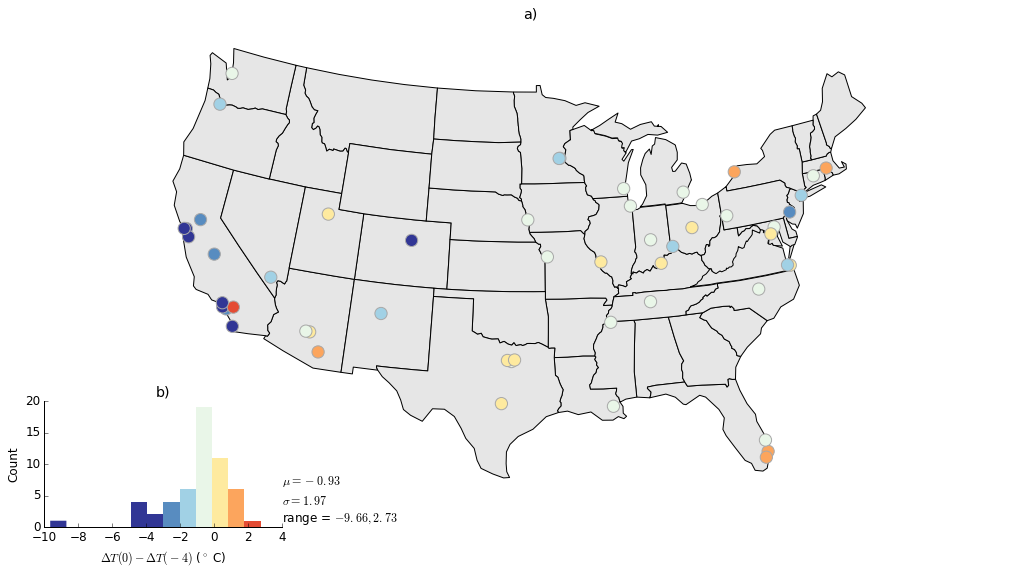

In [1132]:
#S4: Delta T hw
#data = results_df['ttl_lst_squares_beta']
data = compositeUHIDF[0] - compositeUHIDF[-4] 
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = '$\Delta T$', 
                    data_label='$\Delta T (0) - \Delta T(-4)$ ($^\circ$ C)',
                   #c_insignificant = results_df[results_df['hw_pvalueWald']>0.05], 
                                cmap = matplotlib.cm.RdYlBu_r, bounds = np.linspace(-4,4,9),
                ) 
#sub_ax.set_xticks(sub_ax.get_xticks()[::2])
ax.set_title('a)')
sub_ax.set_title('b)')
#plt.savefig(results_filepath+ 'figure2e_2f.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS05.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS05.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'figS05.png', bbox_inches='tight')

In [ ]:
# urban hw
# plt.savefig(results_filepath +'figS06.eps', bbox_inches='tight')
# plt.savefig(results_filepath +'figS06.pdf', bbox_inches='tight')
# plt.savefig(results_filepath +'figS06.png', bbox_inches='tight')

In [ ]:
# rural hw
# plt.savefig(results_filepath +'figS07.eps', bbox_inches='tight')
# plt.savefig(results_filepath +'figS07.pdf', bbox_inches='tight')
# plt.savefig(results_filepath +'figS07.png', bbox_inches='tight')

In [84]:
results_filepath

'plots/version7/'

Baltimore


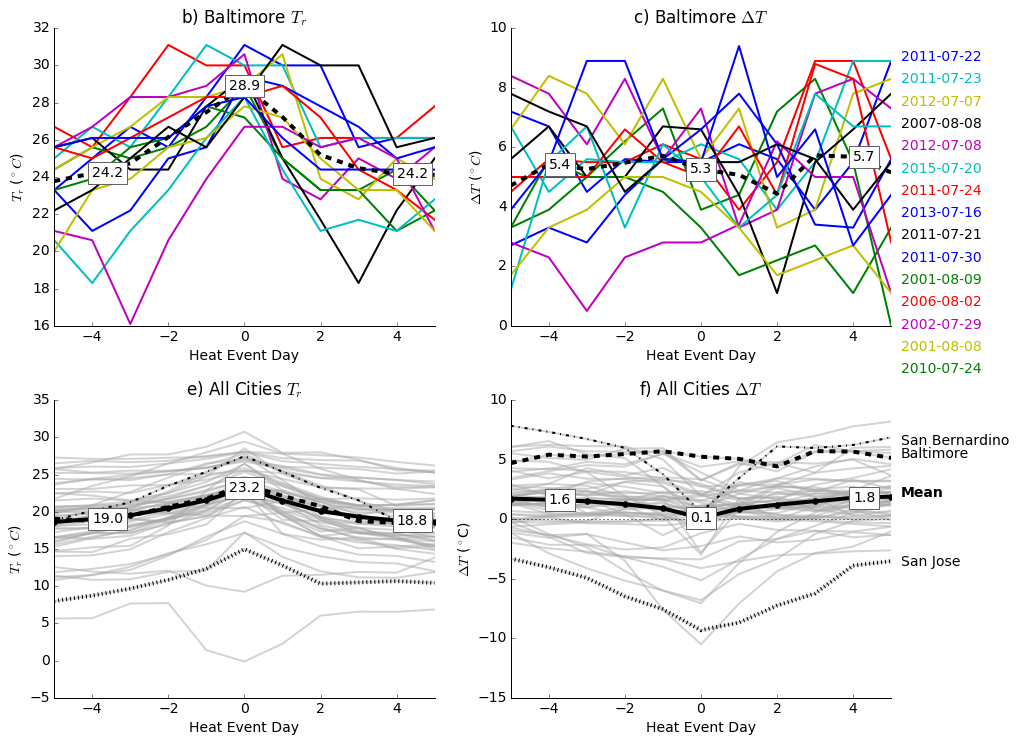

In [209]:
# pc1 hw
# read in data for fig 3
# fig 3 

x = np.arange(-5,6)
compositeTempDF =  pd.read_csv(results_filepath + 'composite_rural_tmin_pc1.csv').set_index('City')# + pd.read_csv(results_filepath + 'composite_rural_tmin_m.csv').set_index('City'))
compositePC1DF =  pd.read_csv(results_filepath + 'composite_pc1.csv').set_index('City')# + pd.read_csv(results_filepath + 'composite_rural_tmin_m.csv').set_index('City'))
compositeTempDF.columns = x
compositeUHIDF  = pd.read_csv(results_filepath + 'composite_UHI_tmin_pc1.csv').set_index('City')
compositeUHIDF.columns = x

city = 'Baltimore'
urbanID = paired_df.loc[city]['Urban station']
ruralID = paired_df.loc[city]['Rural station']
print(city)
urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                     as_dataframe=True, update = False)
ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                     as_dataframe=True, update = False)
#####
###### Import data
######
rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.)  
# drop data with flags here
rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
# extract summertime data 
rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
#for city in cities: 
x = rural_summer
y = urban_summer
x = x[y.dropna().index]
y = y[x.index]
ind = ~np.isnan(y) & ~np.isnan(x)

X = np.array([x[ind].values,y[ind].values])
u, s, v = np.linalg.svd(X-X.mean(), full_matrices=False)
pc1 = pd.Series(v[0], index = x[ind].dropna().index).reindex(urban_tmin.index, fill_value = np.nan)

numhw = 50
final_num_hw = 15#50
#hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
hw_ids = np.argsort(v[0])[0:final_num_hw]
#hw_ids = np.argsort((x[ind]-y[ind])*.5)
hw_dates = x[ind].iloc[hw_ids].index
finalhw = rural_tmin[x[ind].iloc[hw_ids].index]

# Preallocate composite matrices to plot
compositeTemp = np.zeros([final_num_hw, 11])
compositeTemp2 = np.zeros([final_num_hw, 11])
compositeTemppc1 = np.zeros([final_num_hw, 11])
compositeUHI = np.zeros([final_num_hw, 11])
ii = 0
for dates in finalhw.index[0:final_num_hw]: 
    compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeTemp2[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeTemppc1[ii,:] = pc1.fillna(np.nan)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

fig = plt.figure(figsize=[15,12])
bmorec = 'k'

############# a) plot bmore temp
plt.subplot(2,2,1)
x = np.arange(-5,6)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('b) %s $T_r$'%city)
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
prettify_plot()
xx = 1
yy = np.nanmean(compositeTemp,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 5
yy = np.nanmean(compositeTemp,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 9
yy = np.nanmean(compositeTemp,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')


############# b) plot bmore UHI
plt.subplot(2,2,2)
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)
plt.title('c) %s $\Delta T$'%city)
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.xlabel('Heat Event Day')
xx = 1
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 5
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 9
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')

prettify_plot()
a = pd.DataFrame(compositeUHI[:,10],columns=['UHI'], index = finalhw.index)
a['ind'] = np.arange(0, 15)
ii = 0 
for date in a.sort_values('UHI', ascending = False,).index: 
    i = a['ind'][date]
    plt.text(5.25, compositeUHI[0][10]-.75*ii,
             date, color = tHandle[i].get_color(), horizontalalignment='left')#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    ii = ii+1
plt.xlim([-5,5])

############# c) plot all cities temperature
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc[city1], ':', color = 'k', alpha = 1, linewidth = 4, label = '%s'%city1)
plt.plot(x, compositeTempDF.loc[city2], '-.', color = 'k', alpha = 1, linewidth = 2, label = '%s'%city1)
plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heat Event Day')
plt.ylabel('$T_r$ ($^\circ C$)')
plt.title('e) All Cities $T_r$')
plt.xlim([-5,5])
prettify_plot()
xx = -4
yy = compositeTempDF.mean()[xx]
plt.text(-4,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 4
yy = compositeTempDF.mean()[xx]
plt.text(4,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')
############# d) plot all cities UHI
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('f) All Cities $\Delta T$')
prettify_plot()

xx = -4
yy = compositeUHIDF.mean()[xx]
plt.text(-4,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 4
yy = compositeUHIDF.mean()[xx]
plt.text(4,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')
plt.text(5.25,compositeUHIDF[4].loc[city1],'%s'%city1)
plt.text(5.25,compositeUHIDF[4].loc[city2],'%s'%city2)
plt.text(5.25,compositeUHIDF.loc['Baltimore'][5],'Baltimore', color = bmorec)
plt.text(5.25, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')
plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, 
         label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc[city1], '-.', color = 'k', alpha = 1, linewidth = 2, 
         label = '%s'%city1)
plt.plot(x, compositeUHIDF.loc[city2], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, 
         label = '%s'%city2)
#plt.ylim([-12,12])
plt.xlim([-5,5])
prettify_plot()
############# make adjustments and save

fig.subplots_adjust(hspace = .25)
plt.savefig(results_filepath +'figS08.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS08.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'figS08.png', bbox_inches='tight')

Baltimore


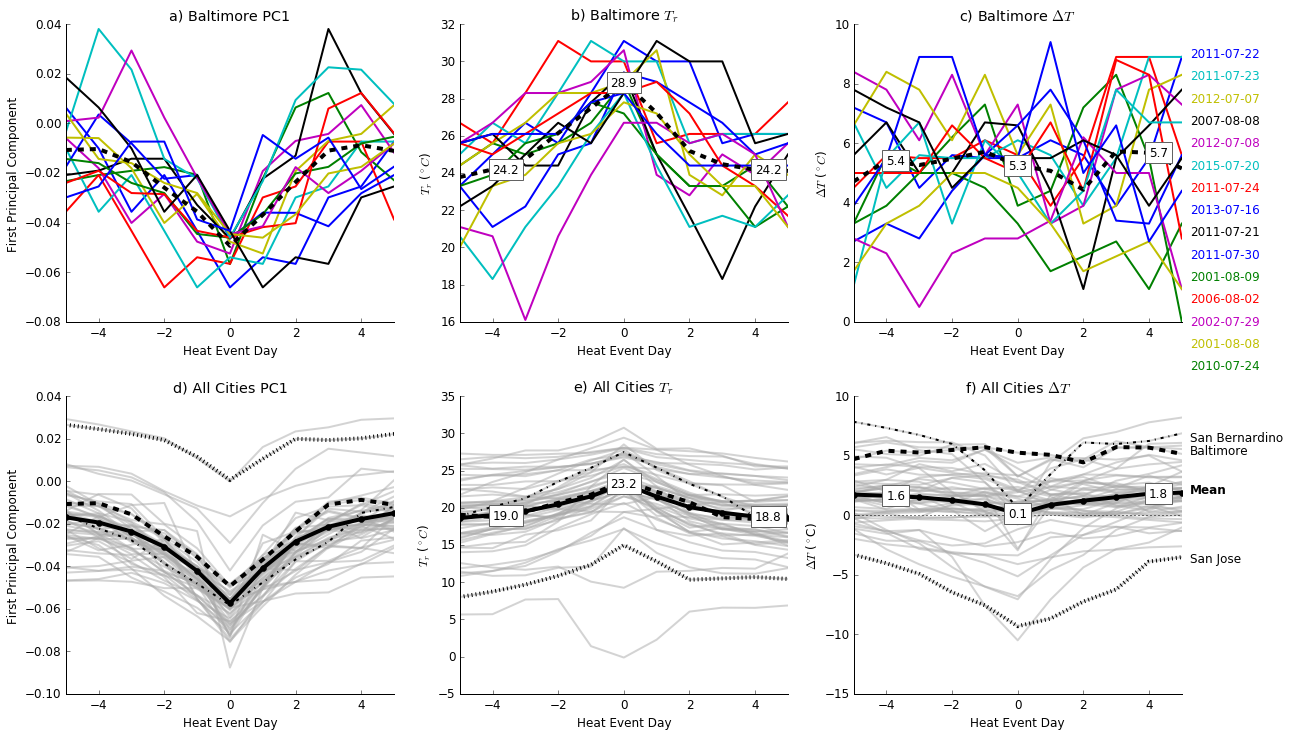

In [93]:
# pc1 hw
# read in data for fig 3
# fig 3 

x = np.arange(-5,6)
compositeTempDF =  pd.read_csv(results_filepath + 'composite_rural_tmin_pc1.csv').set_index('City')# + pd.read_csv(results_filepath + 'composite_rural_tmin_m.csv').set_index('City'))
compositePC1DF =  pd.read_csv(results_filepath + 'composite_pc1.csv').set_index('City')# + pd.read_csv(results_filepath + 'composite_rural_tmin_m.csv').set_index('City'))
compositeTempDF.columns = x
compositeUHIDF  = pd.read_csv(results_filepath + 'composite_UHI_tmin_pc1.csv').set_index('City')
compositeUHIDF.columns = x

city = 'Baltimore'
urbanID = paired_df.loc[city]['Urban station']
ruralID = paired_df.loc[city]['Rural station']
print(city)
# urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
#                                      as_dataframe=True, update = False)
# ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
#                                      as_dataframe=True, update = False)
######
###### Import data
######
rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.)  
# drop data with flags here
rural_tmin.loc[ruraldata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
urban_tmin.loc[urbandata['TMIN']['2000-01-01':]['qflag'].dropna().index] = np.nan
# extract summertime data 
rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
#for city in cities: 
x = rural_summer
y = urban_summer
x = x[y.dropna().index]
y = y[x.index]
ind = ~np.isnan(y) & ~np.isnan(x)

X = np.array([x[ind].values,y[ind].values])
u, s, v = np.linalg.svd(X-X.mean(), full_matrices=False)
pc1 = pd.Series(v[0], index = x[ind].dropna().index).reindex(urban_tmin.index, fill_value = np.nan)

numhw = 50
final_num_hw = 15#50
#hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
hw_ids = np.argsort(v[0])[0:final_num_hw]
#hw_ids = np.argsort((x[ind]-y[ind])*.5)
hw_dates = x[ind].iloc[hw_ids].index
finalhw = rural_tmin[x[ind].iloc[hw_ids].index]

# Preallocate composite matrices to plot
compositeTemp = np.zeros([final_num_hw, 11])
compositeTemp2 = np.zeros([final_num_hw, 11])
compositeTemppc1 = np.zeros([final_num_hw, 11])
compositeUHI = np.zeros([final_num_hw, 11])
ii = 0
for dates in finalhw.index[0:final_num_hw]: 
    compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeTemp2[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeTemppc1[ii,:] = pc1.fillna(np.nan)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

fig = plt.figure(figsize=[20,12])
bmorec = 'k'

############# a) plot bmore temp
plt.subplot(2,3,1)
x = np.arange(-5,6)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemppc1.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemppc1, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s PC1'%city)
plt.ylabel('First Principal Component')
plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
prettify_plot()

plt.xlim([-5,5])

plt.subplot(2,3,2)
x = np.arange(-5,6)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('b) %s $T_r$'%city)
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
prettify_plot()
xx = 1
yy = np.nanmean(compositeTemp,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 5
yy = np.nanmean(compositeTemp,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 9
yy = np.nanmean(compositeTemp,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')


############# b) plot bmore UHI
plt.subplot(2,3,3)
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)
plt.title('c) %s $\Delta T$'%city)
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.xlabel('Heat Event Day')
xx = 1
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 5
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 9
yy = np.nanmean(compositeUHI,axis=0)[xx]
plt.text(xx-5,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')

prettify_plot()
a = pd.DataFrame(compositeUHI[:,10],columns=['UHI'], index = finalhw.index)
a['ind'] = np.arange(0, 15)
ii = 0 
for date in a.sort_values('UHI', ascending = False,).index: 
    i = a['ind'][date]
    plt.text(5.25, compositeUHI[0][10]-.75*ii,
             date, color = tHandle[i].get_color(), horizontalalignment='left')#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    ii = ii+1
plt.xlim([-5,5])

############# c) plot all cities UHI
city1 =  'San Bernardino'#'Tucson'#'Salt Lake City'
city2 = 'San Jose' # 'Austin' #
bmorec = 'k'
plt.subplot(2,3,4)
for i in range(0, compositePC1DF.shape[0]) : 
    plt.plot(x, compositePC1DF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot(x, compositePC1DF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositePC1DF.loc[city1], ':', color = 'k', alpha = 1, linewidth = 4, label = '%s'%city1)
plt.plot(x, compositePC1DF.loc[city2], '-.', color = 'k', alpha = 1, linewidth = 2, label = '%s'%city1)
plt.plot( x, compositePC1DF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heat Event Day')
plt.ylabel('First Principal Component')
plt.title('d) All Cities PC1')
plt.xlim([-5,5])
# plt.ylim([10,32])

prettify_plot()

plt.subplot(2,3,5)
for i in range(0, compositeTempDF.shape[0]) : 
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc[city1], ':', color = 'k', alpha = 1, linewidth = 4, label = '%s'%city1)
plt.plot(x, compositeTempDF.loc[city2], '-.', color = 'k', alpha = 1, linewidth = 2, label = '%s'%city1)
plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heat Event Day')
plt.ylabel('$T_r$ ($^\circ C$)')
plt.title('e) All Cities $T_r$')
plt.xlim([-5,5])
prettify_plot()
xx = -4
yy = compositeTempDF.mean()[xx]
plt.text(-4,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 4
yy = compositeTempDF.mean()[xx]
plt.text(4,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')
############# d) plot all cities UHI
plt.subplot(2,3,6)

for i in range(0, compositeUHIDF.shape[0]) : 
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heat Event Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('f) All Cities $\Delta T$')
prettify_plot()

xx = -4
yy = compositeUHIDF.mean()[xx]
plt.text(-4,yy,'%2.1f'%yy,
             bbox=dict(facecolor='white', edgecolor = '#636363'),
             verticalalignment='center', horizontalalignment='left')
xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='center')
xx = 4
yy = compositeUHIDF.mean()[xx]
plt.text(4,yy,'%2.1f'%yy,
         bbox=dict(facecolor='white', edgecolor = '#636363'),
         verticalalignment='center', horizontalalignment='left')
plt.text(5.25,compositeUHIDF[4].loc[city1],'%s'%city1)
plt.text(5.25,compositeUHIDF[4].loc[city2],'%s'%city2)
plt.text(5.25,compositeUHIDF.loc['Baltimore'][5],'Baltimore', color = bmorec)
plt.text(5.25, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')
plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, 
         label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc[city1], '-.', color = 'k', alpha = 1, linewidth = 2, 
         label = '%s'%city1)
plt.plot(x, compositeUHIDF.loc[city2], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, 
         label = '%s'%city2)
#plt.ylim([-12,12])
plt.xlim([-5,5])
prettify_plot()
############# make adjustments and save

fig.subplots_adjust(hspace = .25)
plt.savefig(results_filepath +'figS08.eps', bbox_inches='tight')
plt.savefig(results_filepath +'figS08.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'figS08.png', bbox_inches='tight')

In [87]:
!pwd

/Users/annascott2/git/heat


In [43]:
# make the table 
results_df['urban station id'] = paired_df['Urban station']
results_df['urban_lcc'] = paired_df['urban_lcc']
results_df['urban_BI'] =paired_df['Urban brightness']
results_df['rural station id'] = paired_df['Rural station']
results_df['rural_lcc'] = paired_df['rural_lcc']
results_df['rural_BI'] = paired_df['Rural brightness']
results_df.to_csv('ScottEtAlTableS1.csv')

# Miscellaneous calculations

In [850]:
# degrees into kilometers
r_earth = 6371
0.25/360*2*np.pi*r_earth

27.798731661139684

In [851]:
r_earth = 6371
0.1/360*2*np.pi*r_earth

11.119492664455874

# Twitter graphic

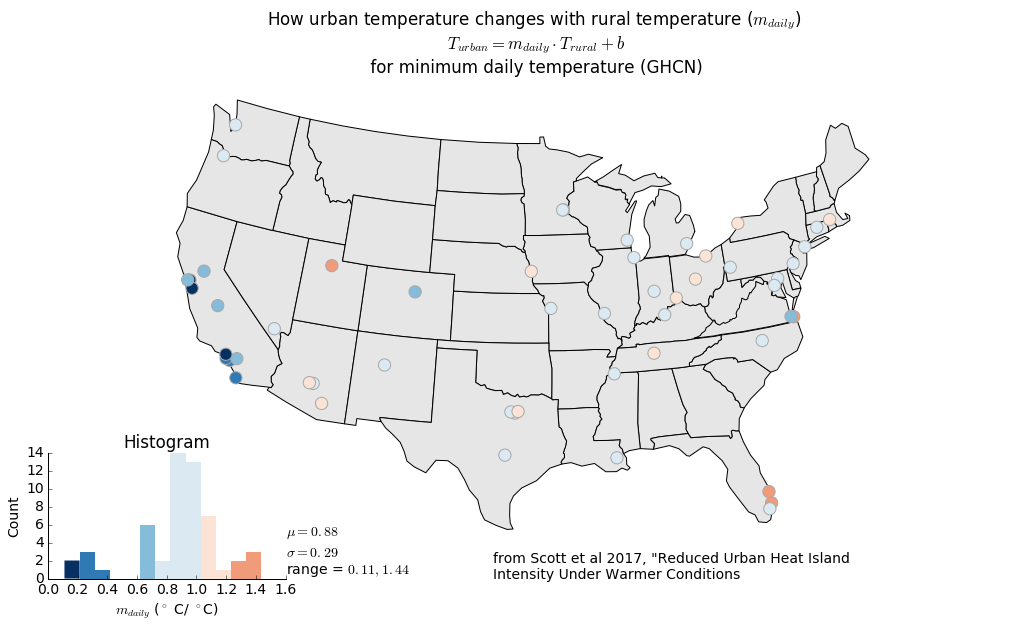

In [96]:
title = 'How urban temperature changes with rural temperature ($m_{daily}$)\n $T_{urban} = m_{daily}\cdot T_{rural} +b$ \n for minimum daily temperature (GHCN)'
# S2: Map of m_daily

data = results_df['ttl_lst_squares_beta']
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Heatwaves', 
                    data_label='$m_{daily}$ ($^\circ$ C/ $^\circ $C)',
                   #c_insignificant = results_df[results_df['hw_pvalueWald']>0.05], 
                                #cmap = matplotlib.cm.YlOrRd,
                                cmap = matplotlib.cm.RdBu_r,
                                bounds = np.linspace(0,2,9),
                ) 
#sub_ax.set_xticks(sub_ax.get_xticks()[::2])
ax.set_title(title)
sub_ax.set_title('Histogram')

plt.text(3,0,'from Scott et al 2017, "Reduced Urban Heat Island \nIntensity Under Warmer Conditions')
# plt.savefig(results_filepath +'figS02.eps', bbox_inches='tight')
# plt.savefig(results_filepath +'figS02.pdf', bbox_inches='tight')
plt.savefig(results_filepath +'twitter_graphic.jpg', bbox_inches='tight')
